# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Project Goals

### Project statement
*For the locations in which Kiva has active loans, your objective is to pair Kiva's data with additional data sources to estimate the welfare level of borrowers in specific regions, based on shared economic and demographic characteristics.*

When we took a look at this prompt for the first time, we weren't really sure how we could go about predicting the welfare need of particular borrowers. Since we wanted to take a much more Machine Learning heavy approach for our solution (since this is for a Machine Learning class after all), we didn't really feel it would be all that impressive to create a model to predict one of the many poverty metrics created by experts in the field. We could have gone another route and attempted to create our own poverty metric, however we are no experts in the area, so even if we wcould create a good model, we wouldn't be able to know whether or not our metric is useful. So then we decided to take a look at the provided data, and try to see if there was something somewhat tangential to this main goal, and we came up with the idea of extracting a Perceived Poverty Index, which in theory could be very useful to Kiva. If we discover that this PPI correlates highly to actual poverty indexes, then Kiva would know that their lenders are fairly good at figuring out who needs to money most. If they do not correlate very much, then Kiva would know that lenders are not funding the loans in more impoverished locations, which could then be acted upon in order to try and balance the lending landscape.

Throughout this project, we hope to figure out just what goes into this PPI, create a model to predict it from information that can be aquired at the time the loan is posted on Kiva, and come up with a few specific use cases for this model depending on the actual outcomes of the model.

# Getting Data

For this project, since we wanted to create a model that would predict this PPI based on information that is readily available at the time which the loan is posted, we didn't want to bring in too much external data, since it might complicate running this system in real time.

The datasets we will be using are obviously the four datasets posted by Kiva for the project, as well as two datasets from [OPHI](https://www.kaggle.com/ophi/mpi) that give us more information regarding regional and national MPI metrics. Here MPI is the Multidimensional Poverty Index, which I have seen and heard everywhere, and seems to be the most popular metric for poverty that is out there.

With that, let's get this thing started

# Datasets

Rather than loading these one at a time as we need them, let's just load them all in at once, and use them when we need them.

In [2]:
# Kiva data
kiva_loans_o = pd.read_csv('kiva-data/kiva_loans.csv')
kiva_mpi_region_locations_o = pd.read_csv('kiva-data/kiva_mpi_region_locations.csv')
loan_theme_ids_o = pd.read_csv('kiva-data/loan_theme_ids.csv')
loan_themes_by_region_o = pd.read_csv('kiva-data/loan_themes_by_region.csv')

# OPHI MPI data
MPI_national_o = pd.read_csv('mpi-data/MPI_national.csv')
MPI_subnational_o = pd.read_csv('mpi-data/MPI_subnational.csv')

# Dataset Cleaning Process

## `kiva_loans`

In [3]:
kiva_loans = kiva_loans_o.copy()
kiva_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null object
disbursed_time        668809 non-null object
funded_time           622874 non-null object
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  499789 non-null object
borrower_genders      666984 non-null object
repayment_interval    671205 non-null object
date                  671205 non

In [4]:
kiva_loans.sample(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
371582,1018145,750.0,875.0,Services,Services,to purchase additional prepaid airtime credit ...,ID,Indonesia,Bandung Timur,IDR,219.0,2016-02-04 07:03:03+00:00,2016-01-18 08:00:00+00:00,NaN,14.0,13,"#Technology, #Parent",male,bullet,2016-02-04
123209,1083759,125.0,125.0,Agriculture,Agriculture,buy a female sheep and dairy feed to increase ...,KE,Kenya,NaN,KES,NaN,2014-09-24 05:53:29+00:00,2014-10-15 23:48:01+00:00,2014-10-01 07:29:10+00:00,3.0,12,NaN,female,monthly,2014-09-24
124679,775637,275.0,500.0,Personal Housing Expenses,Housing,"To buy metal sheeting, beams and prongs to cha...",SV,El Salvador,NaN,USD,81.0,2014-09-26 17:01:02+00:00,2014-09-11 07:00:00+00:00,NaN,20.0,11,"#Parent, #Single Parent, user_favorite",female,monthly,2014-09-26
393578,1040509,575.0,575.0,Metal Shop,Manufacturing,to start his blacksmith workshop,MX,Mexico,"Iztapalapa, D.F.",MXN,294.0,2016-03-17 18:05:48+00:00,2016-03-04 08:00:00+00:00,2016-03-23 18:45:34+00:00,14.0,13,#Biz Durable Asset,male,monthly,2016-03-17
647268,1309479,225.0,225.0,Personal Housing Expenses,Housing,to build a sanitary toilet for her family,PH,Philippines,"Dumaguete, Negros Oriental",PHP,145.0,2017-05-30 02:15:30+00:00,2017-05-10 07:00:00+00:00,2017-06-07 19:19:52+00:00,13.0,1,#Eco-friendly,female,irregular,2017-05-30


### Reformat entries

For this dataset, we need to convert the variables that end in '\_time' to some sort of DateTime format so that it is easier to manipulate that data and compute other values with them.

The features `tags` and `borrower_genders` are both strings of comma-space separated values that represent a list of values, so that will need to be placed in some sort of list.

In [5]:
# Times
time_cols = ['posted_time', 'disbursed_time', 'funded_time', 'date']
for col in time_cols:
    kiva_loans[col] = pd.to_datetime(kiva_loans[col])
    
# Lists
def to_list(strg, sep = ', '):
    if strg == 'nan':
        return []
    return strg.split(sep=sep)

list_cols = ['tags', 'borrower_genders']
for col in list_cols:
    kiva_loans[col] = kiva_loans[col].astype(str).apply(to_list)
    
kiva_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null datetime64[ns]
disbursed_time        668809 non-null datetime64[ns]
funded_time           622874 non-null datetime64[ns]
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null object
borrower_genders      671205 non-null object
repayment_interval    671205 non-null object
date    

### Data Combing

In [6]:
(kiva_loans['posted_time'] - kiva_loans['date']).max()

Timedelta('0 days 23:59:59')

Note that the `date` is just a less precise version of `posted_time`, so `date`. This can be seen by the fact that `date` is always at most just under 24 hours before `posted_time`, so `date` can be dropped.

In [7]:
kiva_loans.drop('date', axis=1, inplace=True)
kiva_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 19 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null datetime64[ns]
disbursed_time        668809 non-null datetime64[ns]
funded_time           622874 non-null datetime64[ns]
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null object
borrower_genders      671205 non-null object
repayment_interval    671205 non-null object
dtypes: 

The rest of the dataset looks good for now, at least in terms of the uniqueness of features. Let's take a final look at this dataset before moving on

In [8]:
kiva_loans.sample(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval
631856,1294291,75.0,75.0,Home Energy,Personal Use,to purchase a solar energy home system and all...,MX,Mexico,"Arroyo Montaña, Xochistlahuaca, Guerrero",MXN,275.0,2017-05-08 16:04:49,2017-04-27 07:00:00,2017-05-13 15:36:48,5.0,3,"[#Eco-friendly, #Technology]",[male],irregular
509361,1169596,275.0,275.0,Food Production/Sales,Food,"to buy three bags of rice, two cans of oil and...",TG,Togo,Attiegou,XOF,296.0,2016-10-18 05:23:15,2016-09-19 07:00:00,2016-10-29 03:31:05,9.0,11,"[#Woman Owned Biz, #Parent, user_favorite]",[female],irregular
350135,997373,3100.0,3100.0,Beverages,Food,"to buy plenty of soft drinks, cosmetics, cream...",GT,Guatemala,"Patulul, Suchitepequez",GTQ,55.0,2015-12-18 15:53:48,2015-11-20 08:00:00,2016-01-21 11:26:22,13.0,95,"[#Parent, #Single Parent, #Woman Owned Biz, us...","[female, female, female, female, female, femal...",monthly
225257,873338,400.0,400.0,Tailoring,Services,to buy sewing supplies.,SV,El Salvador,NaN,USD,167.0,2015-04-21 16:03:28,2015-04-07 07:00:00,2015-05-07 19:26:25,14.0,13,"[#Fabrics, #Parent, #Repeat Borrower, #Woman O...",[female],monthly
632346,1294166,250.0,250.0,Livestock,Agriculture,to buy animal feed for his livestock,TJ,Tajikistan,J. Rasulov,TJS,215.0,2017-05-08 10:59:52,2017-04-08 07:00:00,2017-06-02 17:13:07,13.0,9,"[#Elderly, #Animals, #Woman Owned Biz]",[female],monthly


## `kiva_mpi_region_locations`

In [9]:
kiva_mpi_region_locations = kiva_mpi_region_locations_o.copy()
kiva_mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
LocationName    984 non-null object
ISO             1008 non-null object
country         1008 non-null object
region          984 non-null object
world_region    1008 non-null object
MPI             984 non-null float64
geo             2772 non-null object
lat             892 non-null float64
lon             892 non-null float64
dtypes: float64(3), object(6)
memory usage: 195.0+ KB


In [10]:
kiva_mpi_region_locations.sample(5)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
1851,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
1023,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
1241,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
973,"Al-Hodiedah, Yemen",YEM,Yemen,Al-Hodiedah,Arab States,0.343,"(14.7909118, 42.9708838)",14.790912,42.970884
819,"Moyamba, Sierra Leone",SLE,Sierra Leone,Moyamba,Sub-Saharan Africa,0.569,"(8.1620514, -12.4351923)",8.162051,-12.435192


### Data Combing

This data is rather empty, and since the main purpose of this dataset is to associate MPI data with each loan, we can drop any of the entries that don't include a value for MPI

In [11]:
kiva_mpi_region_locations = kiva_mpi_region_locations[pd.notnull(kiva_mpi_region_locations['MPI'])]
kiva_mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 1007
Data columns (total 9 columns):
LocationName    984 non-null object
ISO             984 non-null object
country         984 non-null object
region          984 non-null object
world_region    984 non-null object
MPI             984 non-null float64
geo             984 non-null object
lat             892 non-null float64
lon             892 non-null float64
dtypes: float64(3), object(6)
memory usage: 76.9+ KB


The data looks quite a bit better now, but there are a few features that might be similar, namely `geo`, `lat`, and `lon`

In [12]:
kiva_mpi_region_locations[['geo', 'lat', 'lon']].sample(5)

,geo,lat,lon
800,"(11.6488639, 24.9042208)",11.648864,24.904221
419,"(33.7733487, 45.1494505)",33.773349,45.149451
167,"(5.3428333, -4.0264183)",5.342833,-4.026418
57,"(11.5247674, -0.1494988)",11.524767,-0.149499
651,"(-21.8466651, 19.1880047)",-21.846665,19.188005


Note how `geo` is just a more complicated version of `lat` and `lon`, so it can be dropped

In [13]:
kiva_mpi_region_locations.drop('geo', axis=1, inplace=True)
kiva_mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 1007
Data columns (total 8 columns):
LocationName    984 non-null object
ISO             984 non-null object
country         984 non-null object
region          984 non-null object
world_region    984 non-null object
MPI             984 non-null float64
lat             892 non-null float64
lon             892 non-null float64
dtypes: float64(3), object(5)
memory usage: 69.2+ KB


Although there are missing values for `lat` and `lon`, these aren't very important, since it isn't very useful to try and predict values based on latitude and longitude, due to the fact that models will try to associate these values continuously with the feature, rather than trying to cluster the data into groups (depending on the model of course, but we don't want our predictions to be based on a numerical value for location). Let's take a final look at the data

In [14]:
kiva_mpi_region_locations.sample(5)

,LocationName,ISO,country,region,world_region,MPI,lat,lon
579,"Shan, Myanmar",MMR,Myanmar,Shan,East Asia and the Pacific,0.194,22.036198,98.133856
788,"Central Darfor, Sudan",SDN,Sudan,Central Darfor,Arab States,0.501,NaN,NaN
302,"N'Zðrðkorð, Guinea",GIN,Guinea,N'Zðrðkorð,Sub-Saharan Africa,0.509,NaN,NaN
481,"Oudomxay, Lao People's Democratic Republic",LAO,Lao People's Democratic Republic,Oudomxay,East Asia and the Pacific,0.248,20.492193,101.889172
598,"Maputo Cidade, Mozambique",MOZ,Mozambique,Maputo Cidade,Sub-Saharan Africa,0.043,-25.891968,32.605135


## `loan_theme_ids`

In [15]:
loan_theme_ids = loan_theme_ids_o.copy()
loan_theme_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779092 entries, 0 to 779091
Data columns (total 4 columns):
id                 779092 non-null int64
Loan Theme ID      764279 non-null object
Loan Theme Type    764279 non-null object
Partner ID         764279 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.8+ MB


In [16]:
loan_theme_ids.sample(5)

,id,Loan Theme ID,Loan Theme Type,Partner ID
70817,723994,a1050000000smst,General,78.0
703720,1366584,a1050000000weyx,General,23.0
596467,1257155,a1050000000QWO4,Youth,80.0
478948,1138384,a1050000000wf0q,General,145.0
156700,811434,a1050000000wf0q,General,145.0


# Data Combing

The first thing to notice about this dataset is that id has many more populated values than the other three columns. Let's take a look at what the data with a NaN `Lean Theme ID`

In [17]:
loan_theme_ids[~pd.notnull(loan_theme_ids['Loan Theme ID'])].sample(10)

,id,Loan Theme ID,Loan Theme Type,Partner ID
425693,1084881,NaN,NaN,NaN
422988,1082176,NaN,NaN,NaN
428221,1087409,NaN,NaN,NaN
426431,1085619,NaN,NaN,NaN
427299,1086487,NaN,NaN,NaN
430967,1090155,NaN,NaN,NaN
428203,1087391,NaN,NaN,NaN
619795,1280900,NaN,NaN,NaN
710697,1373702,NaN,NaN,NaN
651033,1312702,NaN,NaN,NaN


This data will not be very useful for anything, so it can be dropped out of the dataset

In [18]:
loan_theme_ids = loan_theme_ids_o[pd.notnull(loan_theme_ids_o['Loan Theme ID'])]
loan_theme_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 764279 entries, 0 to 779091
Data columns (total 4 columns):
id                 764279 non-null int64
Loan Theme ID      764279 non-null object
Loan Theme Type    764279 non-null object
Partner ID         764279 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 29.2+ MB


The rest of this data should be fine, even if it doesn't end up being used. Let's take a final look before moving on

In [19]:
loan_theme_ids.sample(5)

,id,Loan Theme ID,Loan Theme Type,Partner ID
747196,1411079,a1050000000sjEC,Underserved,247.0
561974,1222145,a1050000002ZLVh,Community Impact Loan,416.0
143546,798203,a1050000000SqOh,At-Risk Youth,81.0
355734,1012550,a1050000000vucG,Underserved,143.0
504277,1163816,a1050000005Ym6l,Underserved,296.0


## `loan_themes_by_region`

In [20]:
loan_themes_by_region = loan_themes_by_region_o.copy()
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 21 columns):
Partner ID            15736 non-null int64
Field Partner Name    15736 non-null object
sector                15736 non-null object
Loan Theme ID         15736 non-null object
Loan Theme Type       15736 non-null object
country               15736 non-null object
forkiva               15736 non-null object
region                15736 non-null object
geocode_old           1200 non-null object
ISO                   15722 non-null object
number                15736 non-null int64
amount                15736 non-null int64
LocationName          15736 non-null object
geocode               13662 non-null object
names                 13661 non-null object
geo                   15736 non-null object
lat                   13662 non-null float64
lon                   13662 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct     

In [21]:
loan_themes_by_region.sample(5)

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,...,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
9330,169,SEF International,General Financial Inclusion,a1050000000wfdB,Startup,Armenia,Yes,Yeghvard,NaN,ARM,...,2725,"Yeghvard, Armenia","[(40.3234491, 44.4869872)]",Yeghvard; Kotayk Province; Armenia,"(40.3234491, 44.4869872)",40.323449,44.486987,ARM,NaN,68.0
10712,181,Credo,General Financial Inclusion,a1050000003vOHH,Startup (Women),Georgia,Yes,Saghvine,NaN,GEO,...,950,"Saghvine, Georgia","[(42.0999606, 43.086913)]",Saghvine; Imereti; Georgia,"(42.0999606, 43.086913)",42.099961,43.086913,GEO,NaN,73.0
5209,126,Paglaum Multi-Purpose Cooperative (PMPC),General Financial Inclusion,a1050000004Dc9C,Agriculture,Philippines,Yes,"Plaridel-Katipa, Lopez Jaena, Misamis Occidental",NaN,PHL,...,425,"Plaridel-Katipa, Lopez Jaena, Misamis Occident...",NaN,NaN,"(1000.0, 1000.0)",NaN,NaN,PHL,NaN,85.0
9444,171,Bai Tushum Bank,General Financial Inclusion,a1050000007QIg8,Agriculture,Kyrgyzstan,No,Batken town,NaN,KGZ,...,4875,"Batken town, Kyrgyzstan","[(40.054846, 70.82091439999999)]",Batken; Batken District; Batken Province; Kyrg...,"(40.054846, 70.82091439999999)",40.054846,70.820914,KGZ,NaN,72.0
6331,136,Gata Daku Multi-purpose Cooperative (GDMPC),General Financial Inclusion,a1050000000wf0h,General,Philippines,No,"Libertad, Sapang Dalaga",NaN,PHL,...,1375,"Libertad, Sapang Dalaga, Philippines","[(8.5615449, 123.6161782)]",Libertad; Misamis Occidental; Northern Mindana...,"(8.5615449, 123.6161782)",8.561545,123.616178,"Northern Mindanao, Philippines","(8.020163499999999, 124.6856509)",61.0


Any data without a `mpi_region` is useless to us since it means we wouldn't be able to associate it with MPI metrics, so we'll drop all rows with null values for that field

In [22]:
loan_themes_by_region = loan_themes_by_region[pd.notnull(loan_themes_by_region['mpi_region'])]
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15722 entries, 0 to 15735
Data columns (total 21 columns):
Partner ID            15722 non-null int64
Field Partner Name    15722 non-null object
sector                15722 non-null object
Loan Theme ID         15722 non-null object
Loan Theme Type       15722 non-null object
country               15722 non-null object
forkiva               15722 non-null object
region                15722 non-null object
geocode_old           1200 non-null object
ISO                   15722 non-null object
number                15722 non-null int64
amount                15722 non-null int64
LocationName          15722 non-null object
geocode               13648 non-null object
names                 13647 non-null object
geo                   15722 non-null object
lat                   13648 non-null float64
lon                   13648 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct     

In this dataset, there are quite a few geolocation based features, let's take a look at what this data looks like

In [23]:
loan_themes_by_region[['geocode_old', 'geocode', 'geo', 'lat', 'lon', 'mpi_region', 'mpi_geo']].sample(10)

,geocode_old,geocode,geo,lat,lon,mpi_region,mpi_geo
15552,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN,PER,NaN
14337,NaN,"[(11.2194391, 78.1677236)]","(11.2194391, 78.1677236)",11.219439,78.167724,IND,NaN
1645,NaN,"[(31.417139, 34.350931)]","(31.417139, 34.350931)",31.417139,34.350931,PSE,NaN
2354,NaN,"[(33.6948309, 35.5812837)]","(33.6948309, 35.5812837)",33.694831,35.581284,LBN,NaN
1207,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN,TJK,NaN
7098,NaN,"[(-1.2815735, 36.8223358)]","(-1.2815735, 36.8223358)",-1.281574,36.822336,"Nyanza, Kenya","(-1.2849963, 36.8272273)"
14723,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN,LSO,NaN
13510,NaN,"[(16.8660694, 96.19513200000002)]","(16.8660694, 96.19513200000002)",16.866069,96.195132,"Yangon, Myanmar","(16.8660694, 96.19513200000002)"
9403,NaN,"[(40.435113, 72.4968189)]","(40.435113, 72.4968189)",40.435113,72.496819,KGZ,NaN
3252,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN,VNM,NaN


Notice that `geocode` and `geo` are basically indentical, and they are both just more complex versions of `lat` and `lon`, so they can be dropped. `geocode_old` is also pretty useless, since it is mostly empty anyways, so it can also be dropped. `mpi_geo` might not be useful either, but it can be dropped later if need be.

In [24]:
loan_themes_by_region.drop(['geocode_old', 'geocode', 'geo'], axis=1, inplace=True)
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15722 entries, 0 to 15735
Data columns (total 18 columns):
Partner ID            15722 non-null int64
Field Partner Name    15722 non-null object
sector                15722 non-null object
Loan Theme ID         15722 non-null object
Loan Theme Type       15722 non-null object
country               15722 non-null object
forkiva               15722 non-null object
region                15722 non-null object
ISO                   15722 non-null object
number                15722 non-null int64
amount                15722 non-null int64
LocationName          15722 non-null object
names                 13647 non-null object
lat                   13648 non-null float64
lon                   13648 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct             14331 non-null float64
dtypes: float64(3), int64(3), object(12)
memory usage: 2.3+ MB


This data looks good for now, let's take a last look before continuing

In [25]:
loan_themes_by_region.sample(5)

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,ISO,number,amount,LocationName,names,lat,lon,mpi_region,mpi_geo,rural_pct
14435,435,Fondesurco,General Financial Inclusion,a1050000004UZpZ,Green,Peru,No,San Sebastian de Sacraca,PER,1,300,"San Sebastian de Sacraca, Peru",Calle Sacramento; Las Gardenias; Santiago de S...,-12.131843,-76.980915,"Lima, Peru","(-12.0463731, -77.042754)",86.0
4227,123,Alalay sa Kaunlaran (ASKI),General Financial Inclusion,a1050000000wf0V,General,Philippines,No,"Salvacion, Alicia, Isabela",PHL,18,8675,"Salvacion, Alicia, Isabela, Philippines",Isabela; Bago Bantay; Quezon City; Metro Manil...,14.659923,121.024474,"Calabarzon, Philippines","(14.1007803, 121.0793705)",84.0
14636,449,Dr. Bronner's / Serendipalm,Other,a1050000005TW4q,Agriculture,Ghana,Yes,Kade,GHA,1,750,"Kade, Ghana",Kade; Kwaebibirem; Eastern Region; Ghana,6.093759,-0.834162,"Central, Ghana","(5.5607846, -1.0586135)",NaN
11218,204,VisionFund Cambodia,General Financial Inclusion,a1050000000R7yw,Higher Education,Cambodia,No,"Banteay Meanchey Province, Preahnet Preah dist...",KHM,1,450,"Banteay Meanchey Province, Preahnet Preah dist...",Preah Netr Preah; Preah Netr Preah; Banteay Me...,13.620930,103.182686,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",100.0
10136,177,Interactuar,General Financial Inclusion,a1050000000wVES,Rural Inclusion,Colombia,No,Lorica,COL,71,36250,"Lorica, Colombia",Santa Cruz de Lorica; Lorica; Cordoba; Colombia,9.237640,-75.813625,"Barranquilla A. M., Colombia","(11.0041072, -74.80698129999999)",16.0


## `MPI_national`

In [26]:
MPI_national = MPI_national_o.copy()
MPI_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
ISO                               102 non-null object
Country                           102 non-null object
MPI Urban                         102 non-null float64
Headcount Ratio Urban             102 non-null float64
Intensity of Deprivation Urban    102 non-null float64
MPI Rural                         102 non-null float64
Headcount Ratio Rural             102 non-null float64
Intensity of Deprivation Rural    102 non-null float64
dtypes: float64(6), object(2)
memory usage: 6.5+ KB


In [27]:
MPI_national.sample(5)

,ISO,Country,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,Intensity of Deprivation Rural
75,TZA,"Tanzania, United Republic of",0.122,27.7,44.3,0.351,68.56,51.2
73,MDG,Madagascar,0.113,24.9,45.3,0.396,73.70,53.8
33,SYR,Syrian Arab Republic,0.011,3.0,35.5,0.023,6.02,38.5
52,VUT,Vanuatu,0.039,9.8,39.3,0.155,36.13,43.0
57,GTM,Guatemala,0.048,10.7,44.5,0.161,35.05,45.9


This data looks good as it is, so nothing needs to be done

## `MPI_subnational`

In [28]:
MPI_subnational = MPI_subnational_o.copy()
MPI_subnational.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 8 columns):
ISO country code                     984 non-null object
Country                              984 non-null object
Sub-national region                  984 non-null object
World region                         984 non-null object
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
dtypes: float64(4), object(4)
memory usage: 61.6+ KB


In [29]:
MPI_subnational.sample(5)

,ISO country code,Country,Sub-national region,World region,MPI National,MPI Regional,Headcount Ratio Regional,Intensity of deprivation Regional
706,NPL,Nepal,Eastern Hill,South Asia,0.126,0.063,15.6,40.6
524,MAR,Morocco,Tanger-Tetouan,Arab States,0.067,0.083,19.0,43.7
846,SWZ,Swaziland,Manzini,Sub-Saharan Africa,0.066,0.041,10.2,39.9
696,NIC,Nicaragua,Chontales,Latin America and Caribbean,0.072,0.082,18.5,44.1
687,NIC,Nicaragua,Jinotega,Latin America and Caribbean,0.072,0.195,40.6,48.1


This data also looks good, so there's nothing to do

# Data Cleaning Code (for reseting datasets)

This is just all of the above code for cleaning the data in one place, in case we need to reset the datasets and don't want to have to run a ton of separate cells

In [30]:
# kiva_loans
kiva_loans = kiva_loans_o.copy()

# Times
time_cols = ['posted_time', 'disbursed_time', 'funded_time', 'date']
for col in time_cols:
    kiva_loans[col] = pd.to_datetime(kiva_loans[col])
    
# Lists
def to_list(strg, sep = ', '):
    if strg == 'nan':
        return []
    return strg.split(sep=sep)

list_cols = ['tags', 'borrower_genders']
for col in list_cols:
    kiva_loans[col] = kiva_loans[col].astype(str).apply(to_list)

kiva_loans.drop('date', axis=1, inplace=True)

# kiva_mpi_region_locations
kiva_mpi_region_locations = kiva_mpi_region_locations_o.copy()
kiva_mpi_region_locations = kiva_mpi_region_locations[pd.notnull(kiva_mpi_region_locations['MPI'])]
kiva_mpi_region_locations.drop('geo', axis=1, inplace=True)

# loan_theme_ids
loan_theme_ids = loan_theme_ids_o.copy()
loan_theme_ids = loan_theme_ids_o[pd.notnull(loan_theme_ids_o['Loan Theme ID'])]

# loan_themes_by_region
loan_themes_by_region = loan_themes_by_region_o.copy()
loan_themes_by_region = loan_themes_by_region[pd.notnull(loan_themes_by_region['mpi_region'])]
loan_themes_by_region.drop(['geocode_old', 'geocode', 'geo'], axis=1, inplace=True)

# MPI_national
MPI_national = MPI_national_o.copy()

# MPI_subnational
MPI_subnational = MPI_subnational_o.copy()

# Merging datasets

Now having 6 separate datasets is not all too useful when it comes to machine learning, so we need to get all of this data aggregated into one large dataset. It will seem as though we get the right path for how to merge all of this data together, but it was discovered through a series of tesing out what can be done, and figuring out what the data contains, which will not be included, since it took a decent amount of time, and some of the important discoveries were wiped away in order to write some other code. In any case, here is the final results of getting all of the data together.

First, we needed to merge each loan with information regarding the type of loan and the partner associated with that loan.

In [31]:
merged_data = kiva_loans.merge(
    loan_theme_ids,
    how='left',
    on='id',
    suffixes=('_kl','_lti')
)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 0 to 671204
Data columns (total 22 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null datetime64[ns]
disbursed_time        668809 non-null datetime64[ns]
funded_time           622874 non-null datetime64[ns]
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null object
borrower_genders      671205 non-null object
repayment_interval    671205 non-null object
Loan The

Now, there are two features specifying who the partner is, `partner_id` and `Partner ID`. Let's see how similar these two are

In [32]:
(merged_data['partner_id'] != merged_data['Partner ID']).sum()

13567

With 13.5 thousand differing values, let's check out how much of those entries are just NaNs

In [33]:
partner_diff = merged_data[merged_data['partner_id'] != merged_data['Partner ID']]
(pd.notnull(partner_diff['partner_id']) & pd.notnull(partner_diff['Partner ID'])).sum()

54

So out of the 13567 reported to have different partner ids, 54 have actually different values. Is there a difference for the amount of data that has one or the other NaN?

In [34]:
(pd.notnull(partner_diff['partner_id']) ^ pd.notnull(partner_diff['Partner ID'])).sum()

6

So only 6 of the entries have one NaN in either of the features.

Since `partner_id` was an original feature of the data, it seems like the more likely candidate to keep, so after filling all NaN values with whatever is in `Partner ID`, we will put them into `Partner ID`, then drop `partner_id` (this is due to merging logistics, which might be apparent below)

In [35]:
merged_data['Partner ID'] = merged_data['partner_id'].fillna(merged_data['Partner ID'])
merged_data.drop('partner_id', axis=1, inplace=True)

Next, we want to merge this data with the dataset that will give us regional information for each partner, including the region for which we have MPI data.

In [36]:
merged_data = merged_data.merge(
    loan_themes_by_region,
    how='left',
    on=['Loan Theme ID', 'Partner ID', 'region'],
    suffixes=('', '_ltbr')
)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 0 to 671204
Data columns (total 36 columns):
id                      671205 non-null int64
funded_amount           671205 non-null float64
loan_amount             671205 non-null float64
activity                671205 non-null object
sector                  671205 non-null object
use                     666973 non-null object
country_code            671197 non-null object
country                 671205 non-null object
region                  614405 non-null object
currency                671205 non-null object
posted_time             671205 non-null datetime64[ns]
disbursed_time          668809 non-null datetime64[ns]
funded_time             622874 non-null datetime64[ns]
term_in_months          671205 non-null float64
lender_count            671205 non-null int64
tags                    671205 non-null object
borrower_genders        671205 non-null object
repayment_interval      671205 non-null object
Loan Theme ID     

Here, any of the data that did not get an `mpi_region` can be dropped, since it means we would be lacking a lot of information for training a model.

In [37]:
merged_data = merged_data[pd.notnull(merged_data['mpi_region'])]
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 1 to 671149
Data columns (total 36 columns):
id                      533461 non-null int64
funded_amount           533461 non-null float64
loan_amount             533461 non-null float64
activity                533461 non-null object
sector                  533461 non-null object
use                     533456 non-null object
country_code            533453 non-null object
country                 533461 non-null object
region                  533461 non-null object
currency                533461 non-null object
posted_time             533461 non-null datetime64[ns]
disbursed_time          533461 non-null datetime64[ns]
funded_time             499549 non-null datetime64[ns]
term_in_months          533461 non-null float64
lender_count            533461 non-null int64
tags                    533461 non-null object
borrower_genders        533461 non-null object
repayment_interval      533461 non-null object
Loan Theme ID     

Now we need to go through the features ending in '\_ltbr', since they collided with existing features, so something needs to be done about them.

The first we will look is `sector`

In [38]:
(merged_data['sector'] != merged_data['sector_ltbr']).sum()

517133

These columns actually have rather different values, so let's take a further look at the data

In [39]:
merged_data[['sector', 'sector_ltbr']].sample(15)

,sector,sector_ltbr
459023,Agriculture,General Financial Inclusion
89042,Agriculture,General Financial Inclusion
100174,Clothing,General Financial Inclusion
599960,Food,General Financial Inclusion
597957,Agriculture,General Financial Inclusion
38740,Food,General Financial Inclusion
170696,Food,General Financial Inclusion
593289,Retail,General Financial Inclusion
37048,Services,General Financial Inclusion
641406,Services,General Financial Inclusion


From this sample we can see that either the features match, or `sector_lbtr` is not very specific. Let's explore a little more

In [40]:
temp = merged_data[merged_data['sector_ltbr'] != 'General Financial Inclusion']
temp = temp[temp['sector'] != temp['sector_ltbr']][['sector', 'sector_ltbr']]
temp.sample(10)

,sector,sector_ltbr
364021,Housing,Other
271436,Services,Other
387214,Transportation,Other
458045,Personal Use,Water and Sanitation
555630,Personal Use,Water and Sanitation
641609,Personal Use,Water and Sanitation
521561,Services,Water and Sanitation
306548,Personal Use,Water and Sanitation
428818,Personal Use,Water and Sanitation
326495,Food,Education


We can see here that many of the rows that don't have "General Financial Inclusion" and that `sector` and `sector_ltbr` don't match, have either "Personal Use" under `sector` or "other" under `sector_ltbr`. Let's see if any data does not follow this trend

In [41]:
temp = temp[temp['sector'] != 'Personal Use']
temp = temp[temp['sector_ltbr'] != 'other']
temp = temp[temp['sector_ltbr'] != 'Other']
temp.sample(10)

,sector,sector_ltbr
224349,Retail,Mobile Money and ICT
275620,Education,Clean Energy
91394,Agriculture,Education
397002,Retail,Clean Energy
167988,Services,Mobile Money and ICT
162825,Education,Agriculture
86707,Clothing,Education
86806,Clothing,Education
601164,Agriculture,Water and Sanitation
668808,Education,Clean Energy


In [42]:
len(temp)

11348

These last few (11,348) entries have rather conflicting results, so we'll leave both features here for now, but if we want to combine them, it shouldn't be too hard, and we would only lose 11k entries

The next feature we need to take a look at is `Loan Theme Type`

In [43]:
(merged_data['Loan Theme Type'] != merged_data['Loan Theme Type_ltbr']).sum()

68

There seems to be some uniqueness within these features, so let's see what they are

In [44]:
merged_data[merged_data['Loan Theme Type'] != merged_data['Loan Theme Type_ltbr']][['Loan Theme Type','Loan Theme Type_ltbr']].drop_duplicates()

,Loan Theme Type,Loan Theme Type_ltbr
70912,Zaf̬n,ZafÍÎn


The only entries which differ have the exact difference as shown above, so one of these can be dropped. Since the '\_ltbr' version of the dataset has more to do with merging, we will keep it, but remove the 'lbtr' from the end.

In [45]:
merged_data['Loan Theme Type'] = merged_data['Loan Theme Type_ltbr']
merged_data.drop('Loan Theme Type_ltbr', axis=1, inplace=True)

The next feature we need to look at is `country`

In [46]:
(merged_data['country'] != merged_data['country_ltbr']).sum()

0

These are identical so we can just drop one

In [47]:
merged_data.drop('country_ltbr', axis=1, inplace=True)

In [48]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 1 to 671149
Data columns (total 34 columns):
id                    533461 non-null int64
funded_amount         533461 non-null float64
loan_amount           533461 non-null float64
activity              533461 non-null object
sector                533461 non-null object
use                   533456 non-null object
country_code          533453 non-null object
country               533461 non-null object
region                533461 non-null object
currency              533461 non-null object
posted_time           533461 non-null datetime64[ns]
disbursed_time        533461 non-null datetime64[ns]
funded_time           499549 non-null datetime64[ns]
term_in_months        533461 non-null float64
lender_count          533461 non-null int64
tags                  533461 non-null object
borrower_genders      533461 non-null object
repayment_interval    533461 non-null object
Loan Theme ID         533461 non-null object
Loan Them

The rest of the features did not collide, so we will just leave them as they are.

Below is the data flow for merging all of the MPI related data, since it contains a lot of collisions, so it will be much faster to merge these smaller ones first and get all of the information clean. The first two datasets we merge are `kiva_mpi_region_locations` and `MPI_subnational` since they have similar data, and we wanted to get any collisions out of the way first.

In [49]:
mpi_info = kiva_mpi_region_locations.merge(
    MPI_subnational,
    how='outer',
    left_on=['country', 'region', 'world_region'],
    right_on=['Country', 'Sub-national region', 'World region'],
    suffixes=('', '_ms')
)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 16 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
MPI                                  984 non-null float64
lat                                  892 non-null float64
lon                                  892 non-null float64
ISO country code                     984 non-null object
Country                              984 non-null object
Sub-national region                  984 non-null object
World region                         984 non-null object
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional 

Since there is a specified 'left_on' and 'right_on', the labels from the second dataset are kept, so they can be removed (`Country`, `Sub-national region`, and `World region`)

In [50]:
mpi_info.drop(['Country', 'Sub-national region', 'World region'], axis=1, inplace=True)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 13 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
MPI                                  984 non-null float64
lat                                  892 non-null float64
lon                                  892 non-null float64
ISO country code                     984 non-null object
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
dtypes: float64(7), object(6)
memory usage: 107.6+ KB


Next, we need to take care of a non-obvious collision, `ISO` and `ISO country code`

In [51]:
(mpi_info['ISO'] != mpi_info['ISO country code']).sum()

0

They are identical, so one can be removed

In [52]:
mpi_info.drop('ISO country code', axis=1, inplace=True)

Next we need to look at `MPI` and either `MPI Regional` or `MPI National`

In [53]:
(mpi_info['MPI'] != mpi_info['MPI Regional']).sum()

0

`MPI` and `MPI Regional` are identical, so one can be removed, which also means that `MPI National` can be left alone

In [54]:
mpi_info.drop('MPI', axis=1, inplace=True)

In [55]:
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 11 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
dtypes: float64(6), object(5)
memory usage: 92.2+ KB


The rest of the features look good, so we can move on to the next merge.

The next dataset is `MPI_national` which contains some nation specific MPI metrics.

In [56]:
mpi_info = mpi_info.merge(
    MPI_national,
    how='left',
    left_on=['country', 'ISO'],
    right_on=['Country', 'ISO'],
    suffixes=('', '_mn')
)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 18 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
Country                              984 non-null object
MPI Urban                            984 non-null float64
Headcount Ratio Urban                984 non-null float64
Intensity of Deprivation Urban       984 non-null float64
MPI Rural                      

Again, we can drop the columns that were merged on from the second dataset (not `ISO` since it was identical and there is still only 1 column with that value)

In [57]:
mpi_info.drop(['Country'], axis=1, inplace=True)

In [58]:
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 17 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
MPI Urban                            984 non-null float64
Headcount Ratio Urban                984 non-null float64
Intensity of Deprivation Urban       984 non-null float64
MPI Rural                            984 non-null float64
Headcount Ratio Rural         

Now this dataset has a lot of potential collisions, so let's look at all of the features with 'mpi' in the name

In [59]:
mpi_info[[key for key in mpi_info.keys() if 'mpi' in key.lower()]].sample(5)

,MPI National,MPI Regional,MPI Urban,MPI Rural
5,0.295,0.313,0.132,0.347
637,0.193,0.283,0.087,0.288
507,0.140,0.291,0.044,0.179
941,0.029,0.017,0.013,0.036
930,0.367,0.400,0.133,0.408


All of these features are different, so they are all good to stay.

Let's look at the features with 'head' in the name (targeting headcount)

In [60]:
mpi_info[[key for key in mpi_info.keys() if 'head' in key.lower()]].sample(5)

,Headcount Ratio Regional,Headcount Ratio Urban,Headcount Ratio Rural
910,4.3,5.4,5.66
492,90.6,60.5,84.86
34,36.3,43.1,84.91
72,4.4,1.6,6.98
406,44.6,10.2,20.69


These features are also all different, so they can all stay.

Next is the features with 'intensity' in the name

In [61]:
mpi_info[[key for key in mpi_info.keys() if 'intensity' in key.lower()]].sample(5)

,Intensity of deprivation Regional,Intensity of Deprivation Urban,Intensity of Deprivation Rural
869,70.7,54.1,65.2
472,49.5,43.4,51.4
902,51.0,47.3,53.7
874,59.2,54.1,65.2
971,49.7,44.0,51.3


Again, they are all different, so they all stay

This is the final dataset for all MPI information, so now it's time to merge it with the main dataset. First, we want to convert the features into `snake_case` because this is python, and also what we prefer

In [62]:
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 17 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
MPI Urban                            984 non-null float64
Headcount Ratio Urban                984 non-null float64
Intensity of Deprivation Urban       984 non-null float64
MPI Rural                            984 non-null float64
Headcount Ratio Rural         

In [63]:
snake_case = lambda colname: colname.lower().replace(' ','_')
mpi_info.rename(snake_case, axis=1, inplace=True)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 17 columns):
locationname                         984 non-null object
iso                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
mpi_national                         984 non-null float64
mpi_regional                         984 non-null float64
headcount_ratio_regional             984 non-null float64
intensity_of_deprivation_regional    983 non-null float64
mpi_urban                            984 non-null float64
headcount_ratio_urban                984 non-null float64
intensity_of_deprivation_urban       984 non-null float64
mpi_rural                            984 non-null float64
headcount_ratio_rural         

We'll do the same to `merged_data` before joining the datasets

In [64]:
snake_case = lambda colname: colname.lower().replace(' ','_')
merged_data.rename(snake_case, axis=1, inplace=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 1 to 671149
Data columns (total 34 columns):
id                    533461 non-null int64
funded_amount         533461 non-null float64
loan_amount           533461 non-null float64
activity              533461 non-null object
sector                533461 non-null object
use                   533456 non-null object
country_code          533453 non-null object
country               533461 non-null object
region                533461 non-null object
currency              533461 non-null object
posted_time           533461 non-null datetime64[ns]
disbursed_time        533461 non-null datetime64[ns]
funded_time           499549 non-null datetime64[ns]
term_in_months        533461 non-null float64
lender_count          533461 non-null int64
tags                  533461 non-null object
borrower_genders      533461 non-null object
repayment_interval    533461 non-null object
loan_theme_id         533461 non-null object
loan_them

So now we need to merge the MPI data with the loan data, and in order to do this, we merge the datasets on `mpi_region` from the loan data, and `locationname` from the MPI information dataset. These happen to represent the same thing, which is something we noticed by exploring through the data.

In [65]:
final_data = merged_data.merge(
    mpi_info,
    how='left',
    left_on='mpi_region',
    right_on='locationname',
    suffixes=('', '_mi')
)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 51 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

We can remove `locationname_mi`, since it was merged on

In [66]:
final_data.drop('locationname_mi', axis=1, inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 50 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

Now we need to start handling any collisions. The first we will handle is `country`

In [67]:
(final_data['country'] != final_data['country_mi']).sum()

95476

A good amount of the data has different values for these features, so let's take a closer look

In [68]:
temp = final_data[final_data['country'] != final_data['country_mi']][['country', 'country_mi']]
temp.sample(10)

,country,country_mi
24586,Paraguay,NaN
418796,The Democratic Republic of the Congo,"Congo, Democratic Republic of the"
262190,Mexico,NaN
57339,Palestine,NaN
376430,India,NaN
5452,Mexico,NaN
171407,Azerbaijan,NaN
300193,Palestine,NaN
281554,India,NaN
389446,Tanzania,NaN


Since country_mi is NaN often, let's only check when this isn't the case

In [69]:
temp = temp[pd.notnull(temp['country_mi'])][['country','country_mi']]
temp.drop_duplicates()

,country,country_mi
35,Tanzania,"Tanzania, United Republic of"
192,Bolivia,"Bolivia, Plurinational State of"
458,Vietnam,Viet Nam
1665,The Democratic Republic of the Congo,"Congo, Democratic Republic of the"
59866,Myanmar (Burma),Myanmar


Since we are done with merging, and `country_mi` has a ton of NaN values, we'll just drop it.

In [70]:
final_data.drop('country_mi', axis=1, inplace=True)

One of the less obvious feature collisions is `mpi_region` and `region_mi`, as opposed to `region_mi` and `region`.

In [71]:
(final_data['mpi_region'] != final_data['region_mi']).sum()

533461

This indicates that the data almost never matches, however taking a closer look, we discovered that `region_mi` is often a substring of `mpi_region`, so let's see how often that is the case

In [72]:
vecin = np.vectorize(str.__contains__)
temp = final_data[['mpi_region', 'region_mi']].dropna()
(~vecin(temp['mpi_region'], temp['region_mi'])).sum()

0

It actually turns out that `region_mi` is always a substring `mpi_region`, so in theory we can remove `region_mi` because it contains less info, however take a look at the data.

In [73]:
temp.sample(10)

,mpi_region,region_mi
501406,"Nord-Ouest, Cameroon",Nord-Ouest
236925,"Dushanbe, Tajikistan",Dushanbe
452899,"Otdar Mean Chey, Cambodia",Otdar Mean Chey
12820,"Central Visayas, Philippines",Central Visayas
84743,"Pursat, Cambodia",Pursat
287784,"Central Visayas, Philippines",Central Visayas
459783,"Western, Kenya",Western
491146,"Western, Kenya",Western
174819,"Kaduna, Nigeria",Kaduna
241859,"Sud-Est, Haiti",Sud-Est


`region_mi` is a decomposed version of `mpi_region`, and it becomes even more obvious if `country` is added

In [74]:
temp = final_data[['mpi_region', 'region_mi', 'country']].dropna()
temp.sample(10)

,mpi_region,region_mi,country
140142,"Eastern, Uganda",Eastern,Uganda
433730,"Punjab, Pakistan",Punjab,Pakistan
527178,"Punjab, Pakistan",Punjab,Pakistan
148042,"Mimaropa, Philippines",Mimaropa,Philippines
435454,"Mountains, Ecuador",Mountains,Ecuador
483114,"Eastern Visayas, Philippines",Eastern Visayas,Philippines
380991,"Nairobi, Kenya",Nairobi,Kenya
94970,"Central Visayas, Philippines",Central Visayas,Philippines
471281,"Western, Kenya",Western,Kenya
31020,"Maputo Cidade, Mozambique",Maputo Cidade,Mozambique


So it is better to keep `region_mi` over `mpi_region`, however we will change the names so it makes a little more sense. Later we realized that `region_mi` had some NaNs, so instead of just renaming it, if `region_mi` is NaN, it takes the value from `mpi_region`

In [75]:
final_data['mpi_region'] = final_data['region_mi'].fillna(final_data['mpi_region'])
final_data.drop('region_mi', axis=1, inplace=True)

The next potential collision are the numerical location features.

In [76]:
final_data[['lat_mi', 'lon_mi', 'mpi_geo']].sample(10)

,lat_mi,lon_mi,mpi_geo
230910,0.258052,30.527910,"(0.2580521, 30.5279096)"
25559,-18.587164,31.262637,"(-18.5871642, 31.2626366)"
173297,0.258052,30.527910,"(0.2580521, 30.5279096)"
38298,31.170406,72.709716,"(31.1704063, 72.7097161)"
385713,13.085114,-86.363020,"(13.0851139, -86.3630197)"
69891,-6.135730,39.362120,"(-6.135729500000001, 39.3621196)"
267090,12.139235,104.565527,"(12.1392352, 104.5655273)"
252294,6.244203,-75.581212,"(6.244203, -75.5812119)"
230296,10.510464,7.416505,"(10.5104642, 7.4165053)"
236032,-16.489689,-68.119294,"(-16.489689, -68.11929359999999)"


As you can see here, `lat_mi` and `lon_mi` are just the decomposed information from `mpi_geo`, so we can drop `mpi_geo`. We will also rename the other features to `mpi_region_lat` and `mpi_region_lon` to make it a little more clear

In [77]:
final_data['mpi_region_lat'] = final_data['lat_mi']
final_data['mpi_region_lon'] = final_data['lon_mi']
final_data.drop(['mpi_geo', 'lat_mi', 'lon_mi'], axis=1, inplace=True)

The last feature collision to check is `iso`.

In [78]:
iso_info = final_data[['iso_mi', 'iso']]
(~pd.notnull(iso_info['iso_mi']) ^ ~pd.notnull(iso_info['iso'])).sum()

74567

You can see above that it is often the case that only one of the features is NaN, so let's see which is more populated

In [79]:
final_data[['iso', 'iso_mi']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 2 columns):
iso       533461 non-null object
iso_mi    458894 non-null object
dtypes: object(2)
memory usage: 12.2+ MB


Since `iso` is fully populated it doesn't matter if `iso_mi` is NaN, but we still need to figure out if they are identical otherwise.

In [80]:
iso_info = iso_info.dropna()
(iso_info['iso'] != iso_info['iso_mi']).sum()

0

Since these features are identical otherwise, we can just drop `iso_mi`

In [81]:
final_data.drop('iso_mi', axis=1, inplace=True)

Finally, the data is all merged, although there is still a good amount of work left to get the data into a usable format. Let's take a look at the current state of the data first before moving on.

In [82]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 46 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

Now we need to get rid of all of the NaN values in this data. The most obvious thing to do would be call `dropna`, but we felt that with a bit of data engineering, we could do better. To do this, we just need to look at each of the features individually and see what we can do.

The first of these features is `use` which is a user input string. If there isn't a value here, it's basically impossible to fill something in, so although we'll probably end up dropping this information, we'll leave it in for now.

The next feature that isn't completely populated is `country_code`. Considering that the `country` feature is fully populated, we won't end up using this feature, so it will probably be dropped.

After this, the next feature is `funded_time`. For now, although there are quite a few missing values, some useful information can be extracted, so we will leave it for now. In any case, the NaN values for this feature indicate that the loan was not fully funded, which is rather useful information

Next we have the field `names`. This is a bit of an odd feature, so let's take a look at the data.

In [83]:
final_data['names'].sample(10)

234355       Catigbian; Bohol; Central Visayas; Philippines
485513             Gujranwala; Gujranwala; Punjab; Pakistan
69626               Wazirabad; Gujranwala; Punjab; Pakistan
1916      Guihulngan City; Negros Oriental; Central Visa...
495585    2; Tyre Road; Lebanon; Center Township; Boone ...
97352       Barranquilla; Barranquilla; Atlantico; Colombia
293146    Hinigaran; Negros Occidental; Western Visayas;...
424839                               N2; baguida lome; Togo
25165                 Narra; Palawan; MIMAROPA; Philippines
321233    Antananarivo; Antananarivo Atsimondrano; Antan...
Name: names, dtype: object

So it looks like this is some sort of alternate names for the region/country for the loan, which is not really helpful, considering how hectic these look like, so there's no need to fill anything.

The next features that are not fully populated are `lat` and `lon`. Now this could be useful to generate some interesting metrics, however we do not intend to, so there is no reason to try to populate this data.

Then next feature with null values is `rural_pct`, which is a percentage of a region which is rural. Let's see what sort of data the locations with NaNs have.

In [84]:
final_data[~pd.notnull(final_data['rural_pct'])].sample(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,headcount_ratio_regional,intensity_of_deprivation_regional,mpi_urban,headcount_ratio_urban,intensity_of_deprivation_urban,mpi_rural,headcount_ratio_rural,intensity_of_deprivation_rural,mpi_region_lat,mpi_region_lon
456917,1247177,125.0,1500.0,Grocery Store,Food,to increase the inventory of his grocery store.,PS,Palestine,"Rafah city, Gaza Strip",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199642,940577,650.0,650.0,Sewing,Services,"to buy 100 yards of fabric, zipper, buttons an...",PH,Philippines,"Tanza, Cavite",PHP,...,7.1,40.3,0.035,8.1,42.7,0.068,13.67,49.9,14.100780,121.079371
340804,1115540,300.0,300.0,Dairy,Agriculture,to buy animal feed.,KE,Kenya,Chuka,KES,...,83.3,61.1,0.076,17.3,43.6,0.245,51.44,47.5,-0.019006,37.648081
482591,1276015,1500.0,1500.0,Renewable Energy Products,Retail,to increase his stock.,HT,Haiti,Port-au-Prince,USD,...,73.6,53.1,0.112,25.2,44.6,0.341,65.90,51.7,18.958274,-72.046816
101081,809653,225.0,225.0,Transportation,Transportation,buy another motorcycle,KE,Kenya,Keroka,KES,...,50.0,44.5,0.076,17.3,43.6,0.245,51.44,47.5,-0.115003,34.851379


Now this is the first feature with potentially useful data that has null values which can't really be filled very easily.

It looks as though it's fairly random data that does not contain a rural_pct. Let's just take a look at that feature before doing anything else in order to understand what the data looks like.

In [85]:
final_data['rural_pct'].sample(10)

448632     95.0
528951    100.0
174244    100.0
161287     69.0
240409     88.0
471493     72.0
434807     90.0
338731     65.0
347443     69.0
142873     69.0
Name: rural_pct, dtype: float64

It's somewhat odd that some places have a rural percentage of 0. Let's look at the data which this is true for.

In [86]:
final_data[final_data['rural_pct'] == 0].sample(10)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,headcount_ratio_regional,intensity_of_deprivation_regional,mpi_urban,headcount_ratio_urban,intensity_of_deprivation_urban,mpi_rural,headcount_ratio_rural,intensity_of_deprivation_rural,mpi_region_lat,mpi_region_lon
107253,817904,200.0,200.0,Fruits & Vegetables,Food,to buy fruit for her husband's business.,PK,Pakistan,Rawalpindi,PKR,...,9.2,42.7,0.087,20.0,43.3,0.299,55.70,53.6,33.729388,73.093146
34594,707879,375.0,375.0,Fruits & Vegetables,Food,to buy more fresh fruits for resale,PK,Pakistan,Lahore,PKR,...,36.6,50.3,0.087,20.0,43.3,0.299,55.70,53.6,31.170406,72.709716
425646,1211700,525.0,525.0,Health,Health,to buy medicines for her brother.,TJ,Tajikistan,Yavan,TJS,...,6.1,34.5,0.020,5.5,36.3,0.065,15.63,41.3,38.559772,68.787038
394449,1176101,575.0,575.0,Embroidery,Arts,"to buy raw material such as gems, pearls, vari...",PK,Pakistan,Multan,PKR,...,36.6,50.3,0.087,20.0,43.3,0.299,55.70,53.6,31.170406,72.709716
425539,1211057,575.0,575.0,Higher education costs,Education,to pay her university tuition at the Tajik Sta...,TJ,Tajikistan,Khujand,TJS,...,8.1,41.2,0.020,5.5,36.3,0.065,15.63,41.3,39.515533,69.097023
388666,1169512,350.0,350.0,Rickshaw,Transportation,to pay the installment for her husband's ricks...,PK,Pakistan,Lahore,PKR,...,36.6,50.3,0.087,20.0,43.3,0.299,55.70,53.6,31.170406,72.709716
12717,673643,1150.0,1150.0,Retail,Retail,to purchase new models of motorcycles and diff...,PK,Pakistan,Wazirabad,PKR,...,9.2,42.7,0.087,20.0,43.3,0.299,55.70,53.6,33.729388,73.093146
122738,841552,175.0,175.0,Grocery Store,Food,to buy 2 sacks of maize and 4 boxes of tomatoe...,TG,Togo,baguida,XOF,...,16.4,40.8,0.081,19.6,41.5,0.356,68.55,51.9,6.172497,1.231362
209377,952243,1250.0,1250.0,Poultry,Agriculture,"to buy layer chicks, traditional chicks and ch...",TZ,Tanzania,Dar es Salaam,TZS,...,30.5,46.9,0.122,27.7,44.3,0.351,68.56,51.2,-6.135730,39.362120
54651,738954,1150.0,1150.0,Food,Food,to pay for more eggs and grocery items needed ...,PH,Philippines,"Silang, Cavite",PHP,...,7.1,40.3,0.035,8.1,42.7,0.068,13.67,49.9,14.100780,121.079371


Using good old fashioned Google to look up some of these regions, it seems that they specify a city, so it makes sense that regions which encompass an entire urban area would have no Rural population. Interesting to know when considering how to fill in NaNs. Now let's see how many of the regions have both missing and filled values for the `rural_pct`

In [87]:
rural_regions = final_data.groupby(['region', 'country'])['rural_pct']

def some_nan(s):
    return len(s) > len(s.dropna())

def all_nan(s):
    return len(s.dropna()) == 0

rural_pct_info = rural_regions.agg([some_nan, all_nan])
(rural_pct_info['some_nan'] & ~rural_pct_info['all_nan']).sum()

128

It looks like 128 region-country pairs have some entries with a NaN, and others with a rural pct. Let's see what regions those are, because we can probably populate the NaNs with values from other entries

In [88]:
odd_regions = rural_pct_info[rural_pct_info['some_nan'] & ~rural_pct_info['all_nan']]
odd_regions.sample(10)

,,some_nan,all_nan
region,country,,
Karachi,Pakistan,True,False
Phnom Penh,Cambodia,True,False
karatina,Kenya,True,False
Tbilisi,Georgia,True,False
Nkhata Bay,Malawi,True,False
"Tanza, Cavite",Philippines,True,False
Chiang Rai,Thailand,True,False
"Binondo, Manila",Philippines,True,False
Las Pinas City,Philippines,True,False


Now I can just go straight to populating the NaNs using data from these regions. The first thing to do is create a second dataset with aggregated data, and join it on the main data in order to fill NaNs

In [89]:
def first_not_na(s):
    dn = s.dropna()
    if len(dn) == 0:
        return np.nan
    return s.dropna().values[0]

rural_pct_info = rural_regions.agg(first_not_na)
default_rural_pct_info = rural_regions.agg(some_nan)

In [90]:
(~pd.notnull(rural_pct_info)).sum(), default_rural_pct_info.sum()

(605, 733)

As you can see here, 128 more region-country pairs have a `rural_pct`, so I will merge and add this data to the main dataset

In [91]:
final_data = final_data.merge(rural_pct_info.to_frame(), how='left', left_on=['region', 'country'], right_index=True, suffixes=('', '_o'))

We can fill in the NaN values in `rural_pct` with the values from `rural_pct_o`

In [92]:
final_data[['rural_pct']].info()
final_data['rural_pct'] = final_data['rural_pct'].fillna(final_data['rural_pct_o'])
final_data[['rural_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    500967 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    516267 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


With an impressive ~16,000 entries added for rural_pct, but there are still values missing. Let's see what we can do by getting country data. For this, rather than just taking the value of one of the entries, we will take the mean of all non null values in each group.

First, we'll start by dropping the new column

In [93]:
final_data.drop('rural_pct_o', axis=1, inplace=True)

In [94]:
rural_country = final_data.groupby('country')['rural_pct']

def non_na_mean(s):
    return s.dropna().mean()

rural_pct_info = rural_country.agg(non_na_mean)
default_rural_pct_info = rural_country.agg(some_nan)

In [95]:
(~pd.notnull(rural_pct_info)).sum(), default_rural_pct_info.sum()

(7, 41)

Now, compared to 41 countries having some NaNs, only 7 countries will, so let's merge this new data with the dataset

In [96]:
final_data = final_data.merge(rural_pct_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

And now we fill in the NaN values with the values from this new column

In [97]:
final_data[['rural_pct']].info()
final_data['rural_pct'] = final_data['rural_pct'].fillna(final_data['rural_pct_o'])
final_data[['rural_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    516267 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    531819 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


In [98]:
len(final_data) - final_data['rural_pct'].count()

1642

Now, only 1642 entries in the data have a NaN value for `rural_pct`. Let's drop the merged column, and check out what the still NaN data looks like

In [99]:
final_data.drop('rural_pct_o', axis=1, inplace=True)
final_data[~pd.notnull(final_data['rural_pct'])]['country'].drop_duplicates()

593           Ukraine
4819            Nepal
98885     Afghanistan
129165        Namibia
446711         Turkey
473677          Benin
523993         Bhutan
Name: country, dtype: object

So here you can see the countries that just don't have a `rural_pct` for whatever reason.

Using data from the [worldbank](https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS?year_high_desc=true) we just looked up the rural percentages (2016) for each of these countries and created a small dataset (rather than importing the csv and combing through it), and filled the rest of these values with this new dataset.

In [100]:
rural_pct_info = {
    'Ukraine': 30,
    'Nepal': 81,
    'Afghanistan': 73,
    'Namibia': 52,
    'Turkey': 26,
    'Benin': 56,
    'Bhutan': 61
}

rural_pct_info = pd.Series(rural_pct_info)
rural_pct_info.to_frame()

,0
Afghanistan,73
Benin,56
Bhutan,61
Namibia,52
Nepal,81
Turkey,26
Ukraine,30


In [101]:
final_data = final_data.merge(rural_pct_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

And finally, we fill in the remaining NaNs for this feature

In [102]:
final_data['rural_pct'] = final_data['rural_pct'].fillna(final_data[0])
final_data[['rural_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    533461 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


As you can see, now every value is filled in. We can also drop the merged column before moving on to the next feature

In [103]:
final_data.drop(0, axis=1, inplace=True)

The next feature to look at is `world_region`. Let's see what this data looks like.

In [104]:
final_data['world_region'].drop_duplicates()

0                       South Asia
9                              NaN
32              Sub-Saharan Africa
34     Latin America and Caribbean
36       East Asia and the Pacific
100        Europe and Central Asia
488                    Arab States
Name: world_region, dtype: object

`world_region` is a global region, which could be a very useful feature, so it would be best to try and fill the NaNs.

Let's look at the countries which have NaNs

In [105]:
final_data[~pd.notnull(final_data['world_region'])]['country'].drop_duplicates()

9                   India
74          United States
81              Palestine
105           Philippines
322              Cambodia
593               Ukraine
660               Albania
661            Tajikistan
695               Georgia
749            Costa Rica
855            Azerbaijan
1052           Kyrgyzstan
1071               Mexico
1318              Armenia
1341             Cameroon
1700             Paraguay
2043                Kenya
2236               Israel
2817            Guatemala
2855         Burkina Faso
2906                Samoa
4437                 Peru
4676              Bolivia
4819                Nepal
5127              Lebanon
9679         South Africa
17303            Zimbabwe
20572            Thailand
26143             Nigeria
31042         El Salvador
35497        Sierra Leone
45632               Haiti
61634             Somalia
75125              Malawi
75362             Moldova
78558               Ghana
80693     Solomon Islands
95355               Egypt
120602      

Let's see if we can do something similar to what we did for `rural_pct`

In [106]:
wr_country = final_data.groupby('country')['world_region']

wr_info = wr_country.agg(first_not_na)
default_wr_info = wr_country.agg(some_nan)

In [107]:
(~pd.notnull(wr_info)).sum(), default_wr_info.sum()

(21, 52)

So now, rather than having 52 countries with potential NaNs for this field, we will only have 21 countries with NaN values

Let's get this data merged and filled in

In [108]:
final_data = final_data.merge(wr_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

Then, we can fill the NaNs in `world_region` with values from `world_region_o`

In [109]:
final_data[['world_region']].info()
final_data['world_region'] = final_data['world_region'].fillna(final_data['world_region_o'])
final_data[['world_region']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
world_region    458894 non-null object
dtypes: object(1)
memory usage: 28.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
world_region    470898 non-null object
dtypes: object(1)
memory usage: 28.1+ MB


So that added around 12,000 more filled entries which is great, but there are still a lot of missing values. We'll leave this one be for now and come back to it if need be. None values here aren't necessarily bad, since they could just be filled with 'Unknown' in order to cluster these regions/countries into a group that might indicate that more data needs to be collected.

The next feature is `mpi_national`, so we'll just go straight ahead and group but the country and join that back on the dataset. First however, `world_region_o` needs to be removed.

In [110]:
final_data.drop('world_region_o', axis=1, inplace=True)

In [111]:
mpi_nat_country = final_data.groupby('country')['mpi_national']

mpi_nat_info = mpi_nat_country.agg(first_not_na)
default_mpi_nat_info = mpi_nat_country.agg(some_nan)

In [112]:
(~pd.notnull(mpi_nat_info)).sum(), default_mpi_nat_info.sum()

(21, 52)

With 31 countries getting values filled in, this should add quite a bit of data

In [113]:
final_data = final_data.merge(mpi_nat_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

In [114]:
final_data[['mpi_national']].info()
final_data['mpi_national'] = final_data['mpi_national'].fillna(final_data['mpi_national_o'])
final_data[['mpi_national']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
mpi_national    458894 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
mpi_national    470898 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


We can just drop the new feature at well

In [115]:
final_data.drop('mpi_national_o', axis=1, inplace=True)

Again, this has some missing values, but there was some NaNs filled in

Next up is `mpi_regional`, `headcount_ratio_regional`, and `intensity_of_deprivation_regional`, which are all tied together, so they can be handled together. Because this is regional data, we will first fill in NaNs using a region based grouping, then take a mean over the country's values to fill the rest.

In [116]:
regional_mpi_groups = final_data[['region', 'country', 'mpi_regional', 'headcount_ratio_regional', 'intensity_of_deprivation_regional']].groupby(['region', 'country'])

reg_mpi_info = regional_mpi_groups.agg(first_not_na)
default_reg_mpi_info = regional_mpi_groups.agg(some_nan)

In [117]:
default_reg_mpi_info.sum() - (~pd.notnull(reg_mpi_info)).sum()

mpi_regional                         0
headcount_ratio_regional             0
intensity_of_deprivation_regional    0
dtype: int64

So it looks as though grouping by region doesn't really help here, so let's go straight to taking an average across the grouping for the country

In [118]:
country_reg_mpi = reg_mpi_info.groupby('country')

country_reg_mpi_info = country_reg_mpi.agg(non_na_mean)
def_country_reg_mpi_info = country_reg_mpi.agg(some_nan)

In [119]:
def_country_reg_mpi_info.sum() - (~pd.notnull(country_reg_mpi_info)).sum()

mpi_regional                         31
headcount_ratio_regional             31
intensity_of_deprivation_regional    31
dtype: int64

Now that's better, let's join this new data with the main dataset

In [120]:
final_data = final_data.merge(country_reg_mpi_info, how='left', left_on='country', right_index=True, suffixes=('', '_o'))

In [121]:
final_data[['mpi_regional', 'headcount_ratio_regional', 'intensity_of_deprivation_regional']].info()
final_data['mpi_regional'] = final_data['mpi_regional'].fillna(final_data['mpi_regional_o'])
final_data['headcount_ratio_regional'] = final_data['headcount_ratio_regional'].fillna(final_data['headcount_ratio_regional_o'])
final_data['intensity_of_deprivation_regional'] = final_data['intensity_of_deprivation_regional'].fillna(final_data['intensity_of_deprivation_regional_o'])
final_data[['mpi_regional', 'headcount_ratio_regional', 'intensity_of_deprivation_regional']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 3 columns):
mpi_regional                         458894 non-null float64
headcount_ratio_regional             458894 non-null float64
intensity_of_deprivation_regional    458877 non-null float64
dtypes: float64(3)
memory usage: 36.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 3 columns):
mpi_regional                         470898 non-null float64
headcount_ratio_regional             470898 non-null float64
intensity_of_deprivation_regional    470898 non-null float64
dtypes: float64(3)
memory usage: 36.3 MB


In [122]:
final_data.drop(['mpi_regional_o', 'headcount_ratio_regional_o', 'intensity_of_deprivation_regional_o'], axis=1, inplace=True)

You can see that a good amount of NaNs were filled in, but there isn't much else to do here, since we simply don't have the information necessary to fill in these missing values.

The last few features can all be done in one lump, with the exception of `mpi_region_lat` and `mpi_region_lon`. Since we don't want the model to find any sorts of correlations based on latitude and longitude (which are usually reflections of other, more indicitive features), they will probably be dropped later, so nothing has to be done.

The rest of the features with NaNs are all country level features, so we will use a similar procedure to fill as many NaNs as possible as we did with the regional MPI information.

In [123]:
nat_mpi_country = final_data[['country', 'mpi_urban', 'headcount_ratio_urban', 'intensity_of_deprivation_urban', 'mpi_rural', 'headcount_ratio_rural', 'intensity_of_deprivation_rural',]].groupby('country')

nat_mpi_info = nat_mpi_country.agg(first_not_na)
def_nat_mpi_info = nat_mpi_country.agg(some_nan)

In [124]:
def_nat_mpi_info.sum() - (~pd.notnull(nat_mpi_info)).sum()

mpi_urban                         31
headcount_ratio_urban             31
intensity_of_deprivation_urban    31
mpi_rural                         31
headcount_ratio_rural             31
intensity_of_deprivation_rural    31
dtype: int64

Again, these featues should fill in the NaNs for 31 countries in the dataset, so let's get it joined

In [125]:
final_data = final_data.merge(nat_mpi_info, how='left', left_on='country', right_index=True, suffixes=('', '_o'))

Now, using a bit of a smarter method to do so, we can fill in the NaNs.

In [126]:
new_keys = nat_mpi_info.keys()
final_data[new_keys].info()
for key in new_keys:
    final_data[key] = final_data[key].fillna(final_data[key+'_o'])
final_data[new_keys].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 6 columns):
mpi_urban                         458894 non-null float64
headcount_ratio_urban             458894 non-null float64
intensity_of_deprivation_urban    458894 non-null float64
mpi_rural                         458894 non-null float64
headcount_ratio_rural             458894 non-null float64
intensity_of_deprivation_rural    458894 non-null float64
dtypes: float64(6)
memory usage: 48.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 6 columns):
mpi_urban                         470898 non-null float64
headcount_ratio_urban             470898 non-null float64
intensity_of_deprivation_urban    470898 non-null float64
mpi_rural                         470898 non-null float64
headcount_ratio_rural             470898 non-null float64
intensity_of_deprivation_rural    470898 non-null float64
dtypes: float64(6)
memory usage: 48.5 MB


So now, pretty much every feature that we could fill NaNs for is as filled as we are able to make it without adding more data, so let's take out the merged features, and take a look at the final set of data.

In [127]:
final_data.drop([k+'_o' for k in new_keys], axis=1, inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 46 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

# Extracting features

Next up in the process of getting this dataset prepared is to extract some features from within the data, so that our model doesn't have to do it for us.

The first thing we can look at is `tags`. Let's print out all the possible tags

In [128]:
def ior(i):
    i = iter(i)
    try:
        s = next(i)
    except StopIteration:
        return None
    for e in i:
        s = s | e
    return s

all_tags = ior(final_data['tags'].apply(set))
all_tags

{'#Animals',
 '#Biz Durable Asset',
 '#Eco-friendly',
 '#Elderly',
 '#Fabrics',
 '#Female Education',
 '#First Loan',
 '#Health and Sanitation',
 '#Hidden Gem',
 '#Inspiring Story',
 '#Interesting Photo',
 '#Job Creator',
 '#Low-profit FP',
 '#Orphan',
 '#Parent',
 '#Post-disbursed',
 '#Refugee',
 '#Repair Renew Replace',
 '#Repeat Borrower',
 '#Schooling',
 '#Single',
 '#Single Parent',
 '#Supporting Family',
 '#Sustainable Ag',
 '#Technology',
 '#Tourism',
 '#Trees',
 '#Unique',
 '#Vegan',
 '#Widowed',
 '#Woman Owned Biz',
 'user_favorite',
 'user_like',
 'volunteer_like',
 'volunteer_pick'}

Since there aren't that many, we can use a sort of One Hot Encoding, but with a list of elements rather than a single element. There were any nice functions to do this for us, so we came up with our own pretty efficient way to do it.

In [129]:
vecin = np.vectorize(list.__contains__)

for tag in all_tags:
    final_data['tag_' + tag] = vecin(final_data['tags'], tag).astype(int)

So now we have quite a few more features

In [130]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 81 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

We can also get another feature for the number of tags, since we don't want to make the model have to figure it out on its own.

In [131]:
final_data['num_tags'] = final_data['tags'].apply(len)

With that, we can't really do anything else with `tags`, so we'll remove it, and take a look at all of the information we extracted

In [132]:
final_data.drop('tags', axis=1, inplace=True)
final_data[[key for key in final_data.keys() if 'tag' in key]].sample(10)

,tag_#Schooling,tag_#Unique,tag_#Hidden Gem,tag_#Repeat Borrower,tag_volunteer_like,tag_#Trees,tag_#Single,tag_#Interesting Photo,tag_#Fabrics,tag_#Refugee,...,tag_#Low-profit FP,tag_#Technology,tag_#Sustainable Ag,tag_#Repair Renew Replace,tag_#Parent,tag_#Eco-friendly,tag_#Vegan,tag_#Elderly,tag_#Widowed,num_tags
506020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,6
171538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,3
476819,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,3
156857,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
53775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368061,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
214230,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


The next features we can extract have to do with the borrower genders. We can rather easily extract the number of borrowers in total, the number males, number of females, and the percentage of male and female borrowers.

In [133]:
final_data['num_borrowers'] = final_data['borrower_genders'].apply(len)
final_data['num_male_borrowers'] = final_data['borrower_genders'].apply(lambda x: x.count('male'))
final_data['ratio_male'] = final_data['num_male_borrowers']/final_data['num_borrowers']
final_data['num_female_borrowers'] = final_data['num_borrowers'] - final_data['num_male_borrowers']
final_data['ratio_female'] = final_data['num_female_borrowers']/final_data['num_borrowers']

With these features extracted, `borrower_genders` can be dropped

In [134]:
final_data.drop('borrower_genders', axis=1, inplace=True)

The next set of features we can extract is the amount of hours it took for a loan to be funded. We will also extract the raw amount of time it took to fund the loan, but we are mainly looking to extract the number of hours.

In [135]:
final_data['time_till_funded'] = final_data['funded_time'] - final_data['posted_time']
final_data['hours_till_funded'] = final_data['time_till_funded'].astype('timedelta64[h]')

In [136]:
final_data[['hours_till_funded']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
hours_till_funded    499549 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


As you can see, quite a few of these values are missing, so let's try to figure out why

In [137]:
final_data[~pd.notnull(final_data['hours_till_funded'])].sample(10)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,tag_#Elderly,tag_#Widowed,num_tags,num_borrowers,num_male_borrowers,ratio_male,num_female_borrowers,ratio_female,time_till_funded,hours_till_funded
529564,1329887,150.0,1550.0,Food Production/Sales,Food,to purchase materials to work in her business ...,NI,Nicaragua,Masaya,NIO,...,1,0,3,3,0,0.0,3,1.0,NaT,NaN
161294,893859,800.0,1000.0,Personal Expenses,Personal Use,to buy a motorcycle.,SV,El Salvador,San Miguel,USD,...,0,0,3,1,1,1.0,0,0.0,NaT,NaN
295171,1051483,1225.0,2100.0,Livestock,Agriculture,to buy rams to resell,ML,Mali,TIMISSA,XOF,...,0,0,5,5,5,1.0,0,0.0,NaT,NaN
162216,894521,775.0,1050.0,Agriculture,Agriculture,"to buy agricultural inputs (manure, fertilizer...",CO,Colombia,Santa Elena,COP,...,0,0,2,1,1,1.0,0,0.0,NaT,NaN
146156,874076,325.0,500.0,Agriculture,Agriculture,to buy farm supplies and pay rent on the land ...,SV,El Salvador,El Transito,USD,...,1,0,3,1,1,1.0,0,0.0,NaT,NaN
150580,879482,300.0,550.0,Retail,Retail,buy more stock of building stones.,KE,Kenya,Kilifi,KES,...,0,0,2,1,1,1.0,0,0.0,NaT,NaN
351827,1128331,175.0,500.0,Farming,Agriculture,to buy farm inputs,KE,Kenya,Kenyenya,KES,...,0,0,4,1,0,0.0,1,1.0,NaT,NaN
146396,874073,575.0,825.0,Restaurant,Food,"to buy ingredients like chicken, oil, and flour.",CO,Colombia,Chigorodo,COP,...,1,0,2,1,0,0.0,1,1.0,NaT,NaN
305447,1062688,125.0,300.0,General Store,Retail,"to buy more stock of sugar, bread, flour and o...",KE,Kenya,Maua,KES,...,0,0,4,1,0,0.0,1,1.0,NaT,NaN
70837,763767,375.0,1150.0,Personal Housing Expenses,Housing,to renovate her house.,PH,Philippines,"Oroquieta-Tipan, Oroquieta City, Mis. Occ",PHP,...,0,0,1,1,0,0.0,1,1.0,NaT,NaN


It looks like the entries that are lacking a `funded_time` actually have not been fully funded yet (or will never be funded). This will be helpful for generating a good metric to determine the public perception of the welfare/poverty level of the borrower. These NaNs have to be filled however, in a way that won't ruin the data. Let's take a look at just the time values within this dataset.

In [138]:
final_data[~pd.notnull(final_data['hours_till_funded'])][['funded_time', 'posted_time', 'disbursed_time']].sample(10)

,funded_time,posted_time,disbursed_time
442822,NaT,2017-02-02 09:18:26,2017-01-25 08:00:00
319670,NaT,2016-05-31 02:57:53,2016-05-24 07:00:00
350030,NaT,2016-07-29 14:09:46,2016-07-06 07:00:00
106595,NaT,2014-12-18 20:06:12,2014-12-09 08:00:00
71912,NaT,2014-09-08 06:05:44,2014-08-19 07:00:00
340138,NaT,2016-07-12 15:19:47,2016-07-08 07:00:00
64310,NaT,2014-08-12 15:42:06,2014-08-07 07:00:00
152208,NaT,2015-05-08 11:59:34,2015-04-15 07:00:00
201768,NaT,2015-09-04 14:51:38,2015-08-24 07:00:00
307912,NaT,2016-05-06 09:34:13,2016-04-13 07:00:00


So it looks like these loans were actually distributed before they were posted (or at least a portion of the loans), so computing a funding velocity is not really possible. What could be useful here is to use the maximum amount of hours required to fund a particular amount of money, and plot those results to see if there are any trends 

In [139]:
data = final_data[['loan_amount', 'hours_till_funded']].dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499549 entries, 0 to 533452
Data columns (total 2 columns):
loan_amount          499549 non-null float64
hours_till_funded    499549 non-null float64
dtypes: float64(2)
memory usage: 11.4 MB


In [140]:
maxes = data.groupby('loan_amount').max()
maxes.sample(10)

,hours_till_funded
loan_amount,
14675.0,80.0
2250.0,1198.0
1925.0,1538.0
7875.0,290.0
1425.0,1675.0
2025.0,1182.0
10200.0,284.0
1175.0,1545.0
275.0,1481.0


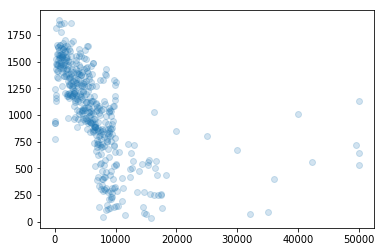

In [141]:
X = maxes.index
y = maxes['hours_till_funded']
plt.scatter(X, y, alpha=0.2)
plt.show()

It's interesting to see that downward trend. Although this is only maximums, it could shed light onto some issue Kiva has with promoting some of the loans that require more money, rather than promoting the loans for people who really need it. Let's take a look at the average and minimums as well, just to get an idea.

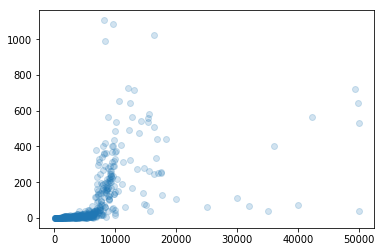

In [142]:
loan_groups = data.groupby('loan_amount')
mins = loan_groups.min()
means = loan_groups.mean()

plt.scatter(mins.index, mins['hours_till_funded'], alpha=0.2)
plt.show()

This minimums looked just about as I expected, with the minimums following a sort of exponential function. Smaller loans are bound to be able to be funded faster than bigger loans, so this makes sense

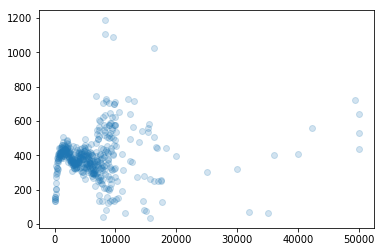

In [143]:
plt.scatter(means.index, means['hours_till_funded'], alpha=0.2)

Now the mean looks odd and intriguing. It has this sharp rise, then slowly fluctuates in a downward trend, which is odd considering there is no normalization. This indicates that some of the larger loans are simply being funded faster than smaller loans. Let's see if this just has to do with the number of loans in each bucket.

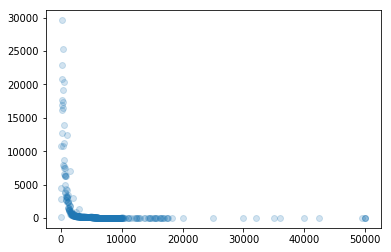

In [144]:
counts = loan_groups.count()

plt.scatter(counts.index, counts['hours_till_funded'], alpha=0.2)
plt.show()

This looks as expected. Maybe the average funding velocity (`loan_amount`/`hours_till_funded`) can give insights into the odd shape of the average funding time.

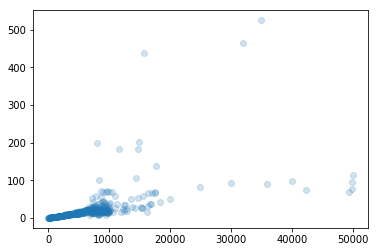

In [145]:
plt.scatter(means.index, means.index/means['hours_till_funded'], alpha=0.2)
plt.show()

So this is a very interesting graph. It implies that people tend to fund larger loans faster than smaller loans. This could be due to the amount of loans at each loan amount. If a lender lends money to one project from each price range, then it's obvious that due to the fact that there are fewer large loans, that they would get funded more. Still, this could be viewed as an issue, especially if Kiva wants the money to go to those who need it the most.

Now back to the task of populating the NaNs for the `hours_till_funded` feature, since we want a way to represent that this loan never got fully funded, but do so in a way that just makes the data significant, rather than leave them as NaN or give each of the loans that didn't get funded some arbitrarily large about of time to get funded. This is important so that whatever model we generate treates outliers locally rather than globally. We don't want the model to see the data and say "Oh wow look at these outliers", we want it to see the data as a whole have no particular outliers, but when looking at a subset of the data, see outliers. What we plan on doing is computing the average funding velocity (of the loans for which one can be computed) for a particular loan size (using LinearRegression), the use it to compute a prospective `expected_hours_till_funded`. We will then, under the assumption that the loan reached the amount it was funded when it reached the expected hours till funded, divide the expected hours by the percent of the loan that was funded for all of the loans that weren't fully funded, and use this new value as the hours till funded.

In [146]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

X = means.index.values.reshape(-1, 1)
y = (means.index/means['hours_till_funded'])

lin_reg.fit(X[:100], y[:100])
preds = lin_reg.predict(X)

The reason that we are only using part of the data to fit the linear regression is to ensure that the intercept is positive. Otherwise the smaller loans get a negative expected funing velocity, which isn't very useful

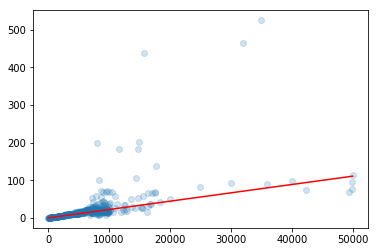

In [147]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X, preds, c='r')

Although this might not be perfect, especially for higher values, it should be a rather good way to predict how long a certain loan should take, based on how large that loan is. And even though this line only takes into account the first 100 loan amounts, it still produces line that fits the data rather well.

In [148]:
lin_reg.coef_[0], lin_reg.intercept_

(0.0022150186161036447, 0.27150944584848746)

In [149]:
f = lambda x: lin_reg.coef_[0]*x + lin_reg.intercept_

final_data['expected_funding_velocity'] = final_data['loan_amount'].apply(f)
final_data['expected_hours_till_funded'] = final_data['loan_amount']/final_data['expected_funding_velocity']

Next we need a percentage of the loan that way funded, and at the same time we will extract a boolean feature denoting whether or not the loan was fully funded.

In [150]:
final_data['percent_funded'] = final_data['funded_amount']/final_data['loan_amount']
final_data['fully_funded'] = final_data['funded_amount'] >= final_data['loan_amount']

Finally we can compute a theoretical amount of hours till loans that weren't fully funded might be funded by. This is bound to overshoot, but they are supposed to be large values since we want the model to take these into affect when determining how long it will take for a loan to be funded.

In [151]:
final_data['hours_till_funded'] = final_data['hours_till_funded'].fillna(final_data['expected_hours_till_funded']/final_data['percent_funded'])

Let's check out what this looks like. The red points are data that wasn't fully funded, whereas the green points were

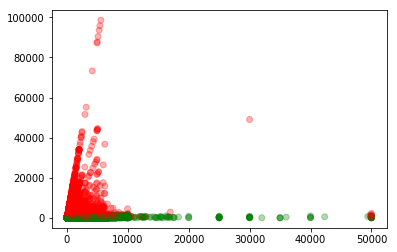

In [152]:
colors = ('r', 'g')
get_c = lambda i: colors[i]
inst_cols = final_data['fully_funded'].apply(get_c)
plt.scatter(final_data['loan_amount'], final_data['hours_till_funded'], c=inst_cols, alpha=0.3)
plt.show()

Here you can see that the red points in the data contain the values which we populated. This data might be a little concerning, given by how skewed the data is, but the point is for the loans that were not fully funded to be casted as outliers, but in an intelligent way, rather than just giving them some arbitrary value. Let's see how much of the data has a really high value (let's say greater than 2100 hours, since is looks like most of the green data stops about there. This is about 2.9 months)

In [153]:
(final_data['hours_till_funded'] > 2100).sum()

6577

Although this might be considered a lot, keep in mind the amount of data that we have in total. This is just a rather small portion of all the data we have.

In [154]:
((final_data['hours_till_funded'] > 2100).sum())/len(final_data)

0.012328923763874023

A whopping 1.2% of the data consists of data that falls way outside the trend, which is nothing to worry about. In fact, we hope that the model will pick up the significance of these loans in order to predict when an incoming loan has a high chance of taking way too long to be funded. This even includes a few 'inf' values, since some of the loans listed did not get funded at all. Let's see how many of those there are.

In [155]:
(final_data['hours_till_funded'] == float('inf')).sum()

2113

Note that this means there are only 6577 - 2113 = 4464 actual outliers, whereas the 'inf' values are a result of unfunded project, which we wouldn't describe as outliers, but just the way to numerically denote an unfunded project. This also has the implication (due to the fantastic properties of Python) that the `loan_amount`/`hours_till_funded` will be 0 whenever `hours_till_funded` is 'inf'.

In [156]:
final_data['funding_velocity'] = final_data['loan_amount']/final_data['hours_till_funded']

In [157]:
final_data[final_data['hours_till_funded'] == float('inf')][['hours_till_funded', 'funding_velocity']].drop_duplicates()

,hours_till_funded,funding_velocity
173914,inf,0.0


As you can see, all of the entries with 'inf' `hours_till_funded` also have 0 `funding_velocity`, which is great, because we don't have to do any more work for this feature, let's see what this data looks like plotted out

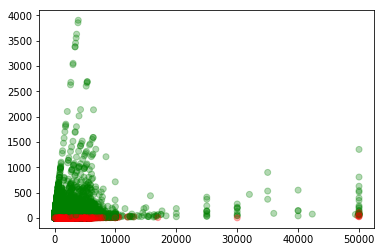

In [158]:
plt.scatter(final_data['loan_amount'], final_data['funding_velocity'], c=inst_cols, alpha=0.3)
plt.show()

Here, you can see that pretty much all of the red points have a rather low funding velocity, which was the intention of the formula used to fill in these null values. You can also see the slight upward trend like in the averages, which is a good indication that this data we added will work well with the model. Something else to notice is that quite a few of the filled in values seem rather normal. This ideally indicates that the loan was nearly funded, so rather than placing a significant marker on that data (like an infinite or really large hours_till_funded), the formula created a more reasonable guess as to what it might have been.

The last feature we can extract is `month_posted`, which we will explain our reasoning for later with some visualizations

In [159]:
final_data['month_posted'] = final_data['posted_time'].apply(lambda date: date.month)

In [160]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 93 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

# Visualizations

Now we can take a better look of this data, now that it's as full as we could ever make it.

In [187]:
data = final_data.copy()

In [188]:
(data['funding_velocity'] == float('inf')).sum()

1100

Not really sure why there are a few infinite values for `funding_velocity`... I guess this means they were funded instantly/before the loan was posted. I'm going to remove these for now to make visualization possible.

In [189]:
# remove inf for plotting
plottable_data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["funding_velocity"], how="all")

In [190]:
data = plottable_data.copy()

## Correlations

In [191]:
# correlations

numeric_data = data.select_dtypes(include=['float64'])

corr = numeric_data.corr()
corr["funding_velocity"]

funded_amount                        0.205840
loan_amount                          0.194283
term_in_months                      -0.028576
partner_id                          -0.040275
number                               0.036571
amount                               0.066287
lat                                 -0.062756
lon                                 -0.052382
rural_pct                            0.008764
mpi_national                        -0.027869
mpi_regional                        -0.025884
headcount_ratio_regional            -0.028228
intensity_of_deprivation_regional   -0.031656
mpi_urban                           -0.023638
headcount_ratio_urban               -0.025202
intensity_of_deprivation_urban      -0.037798
mpi_rural                           -0.022811
headcount_ratio_rural               -0.021330
intensity_of_deprivation_rural      -0.040817
mpi_region_lat                      -0.045762
mpi_region_lon                      -0.035605
ratio_male                        

No obvious correlations, at this point, apart from the `loan_amount` and `expected_funding_velocity` relationships we should expect.

In [192]:
corr["mpi_regional"]

funded_amount                        0.036962
loan_amount                          0.041569
term_in_months                      -0.006072
partner_id                           0.267224
number                               0.163880
amount                               0.029473
lat                                 -0.219723
lon                                 -0.069291
rural_pct                            0.203573
mpi_national                         0.765262
mpi_regional                         1.000000
headcount_ratio_regional             0.987892
intensity_of_deprivation_regional    0.635439
mpi_urban                            0.700235
headcount_ratio_urban                0.710108
intensity_of_deprivation_urban       0.566479
mpi_rural                            0.749011
headcount_ratio_rural                0.753715
intensity_of_deprivation_rural       0.482157
mpi_region_lat                      -0.227152
mpi_region_lon                      -0.070451
ratio_male                        

Nothing super surprising here. It's worth noting that `mpi_regional` and `headcount_ratio_regional` are nearly perfectly correlated.

## Temporal features

In [193]:
loan_timing = pd.DataFrame(data[['id', 'posted_time']])

In [194]:
loan_timing['hour_posted'] = data.posted_time.map(lambda row: row.hour)
loan_timing['weekday_posted'] = data.posted_time.map(lambda row: row.weekday())

In [195]:
loans_with_timing = pd.merge(loan_timing, data, on="id")

### Time of day/week/year posted

In [196]:
data_no_outliers = loans_with_timing.sort_values('funding_velocity', ascending=True)

In [197]:
data_no_outliers = data_no_outliers.head(round(len(data_no_outliers) * .98))

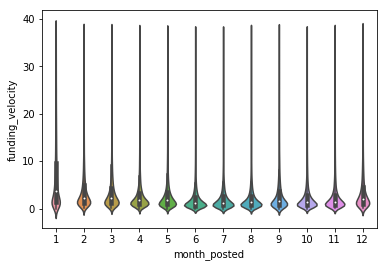

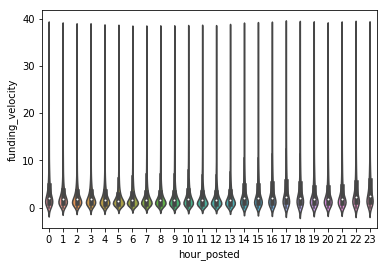

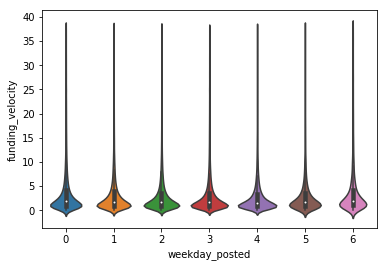

In [198]:
sns.violinplot(x="month_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

sns.violinplot(x="hour_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

sns.violinplot(x="weekday_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

In [199]:
loans_with_timing.groupby('month_posted').mean()['funding_velocity']

month_posted
1     16.076731
2      7.124660
3      7.366669
4      3.446271
5      3.814926
6      3.222456
7      2.971670
8      3.405253
9      5.625670
10     3.262800
11     3.901473
12     9.642497
Name: funding_velocity, dtype: float64

It looks like loans posted in the winter (particularly around the holidays) generally have a higher funding velocity.

### Velocity over time

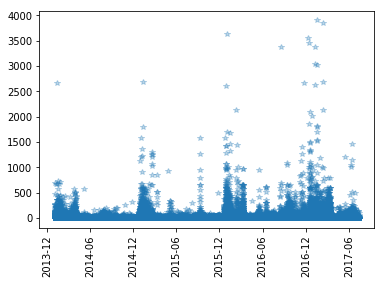

In [201]:
df = data.sort_values('posted_time', ascending=True)
plt.plot(df['posted_time'], df['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

Here again, we can see the trend for a spike in funding velocity around Dec/Jan every year.

## Loan Purpose

We have three features related to loan purpose: `sector`, `activity`, and `loan_theme_type`.

In [202]:
colors = ['#455e8e', '#7489ad']

def plot_categorical(category, dataset=data, numeric_feature='funding_velocity'):
    plt.figure(figsize=(15,8))
    count = round(dataset.groupby([category])[numeric_feature].mean().sort_values(ascending=False), 2)
    sns.barplot(count.values, count.index, )
    for i, v in enumerate(count.values):
        plt.text(0.8,i,v,color='k',fontsize=12)
    plt.xlabel(numeric_feature, fontsize=20)
    plt.ylabel(category, fontsize=20)
    plt.show()
    
def plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='sector', 
                     d=data, 
                     scale_first=True):
    # average by category, sort
    count_a = d.groupby([category])[feature_a].mean().sort_values(ascending=False).to_frame()
    count_a[category] = count_a.index.values
    # average by category
    count_b = d.groupby([category])[feature_b].mean().to_frame()
    count_b[category] = count_b.index.values
    # merge on sorted category
    counts = count_a.merge(count_b, how='left', on=category)
    # scale if necessary, plot
    if scale_first:
        counts[feature_a] = counts[feature_a]*100 # scale
    counts.plot(kind='bar', stacked=True, color=colors)

### Sector

In [203]:
len(data['sector'].unique())

15

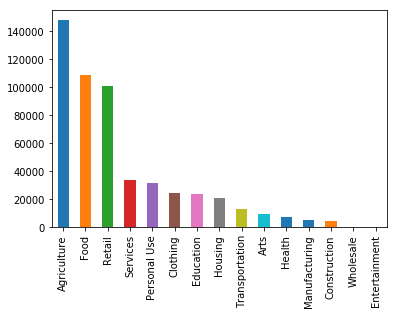

In [204]:
data.sector.value_counts().plot.bar()

This is by far our least granular category, with 15 values.

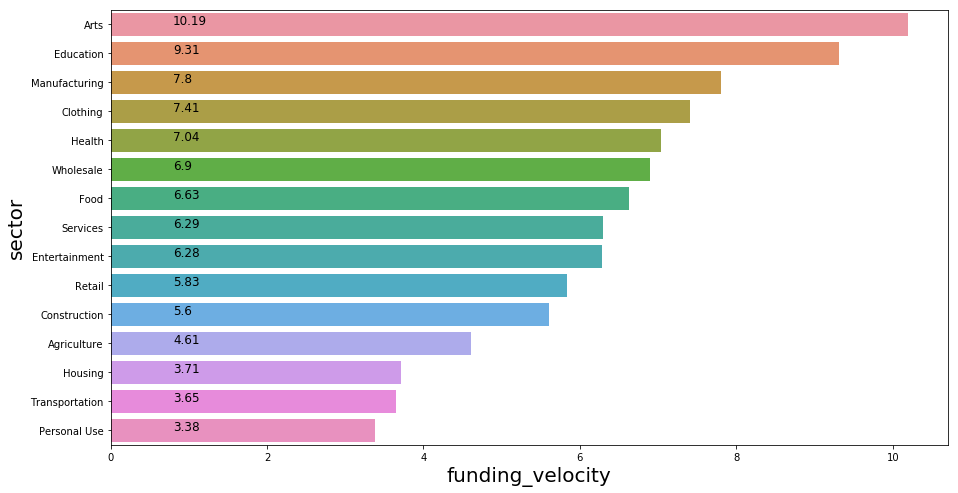

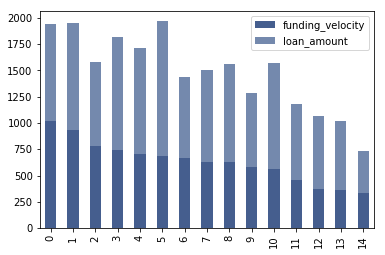

In [205]:
plot_categorical('sector', data)

plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='sector', 
                     d=data, 
                     scale_first=True)

Difference in `funding_velocity` for each category does not vary too closely with `loan_amount`, interestingly.

### Activity

In [206]:
len(data['activity'].unique())

163

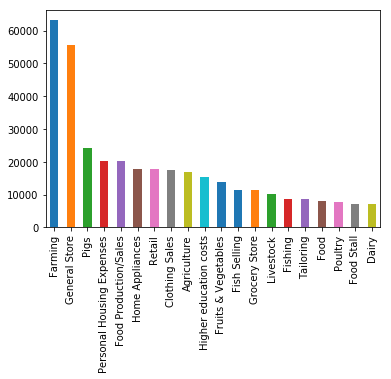

In [207]:
data.activity.value_counts().head(20).plot.bar()

Activity is significantly finer grained, with 163 values. Aside from being more fine-grained, the categories are very similar.

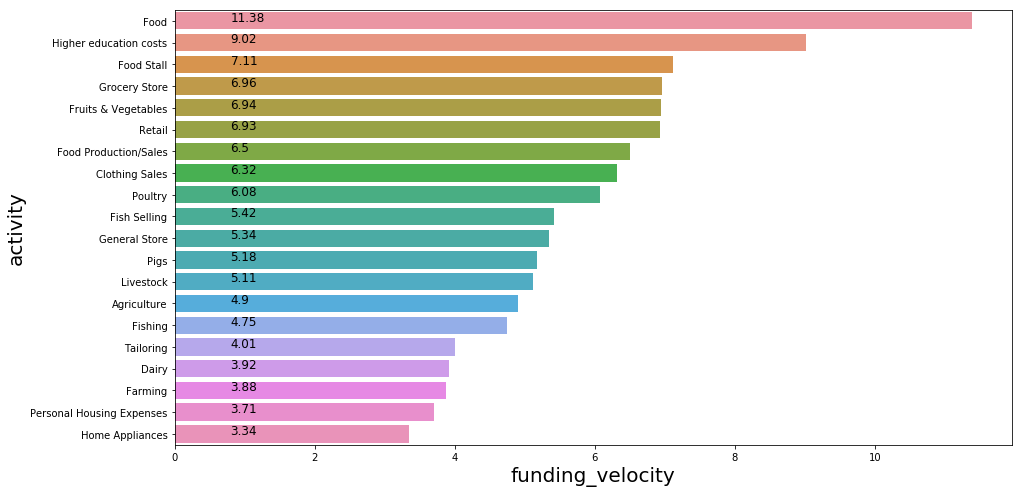

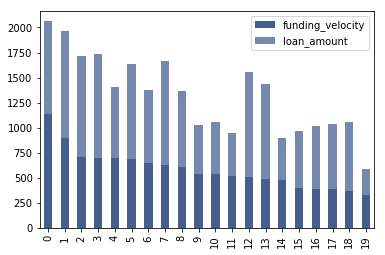

In [208]:
# plot velocity for most common activities
top_activities = data.activity.value_counts().head(20).index.values
activities = data.loc[data['activity'].isin(top_activities)]

plot_categorical('activity', activities)

plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='activity', 
                     d=activities, 
                     scale_first=True)

### Loan theme type

In [209]:
len(data['loan_theme_type'].unique())

160

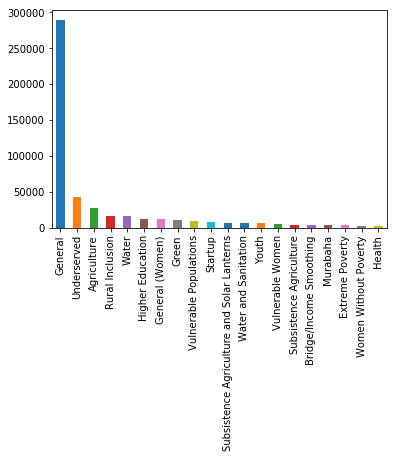

In [210]:
data.loan_theme_type.value_counts().head(20).plot.bar()

`loan_theme_type` is slightly less fine-grained than `activity`, with 110 values. The categories here are not the same, however. Rather than just looking at the usage, `loan_theme_type` takes into account qualities of the borrower (women entrepeneurs, for example.)

In [211]:
print((data.loan_theme_type != 'General').sum() / data.shape[0])
print((data.loan_theme_type == 'Women Entrepreneurs').sum())

0.45838256371146646
2077


40% of our data falls into the `general` theme.

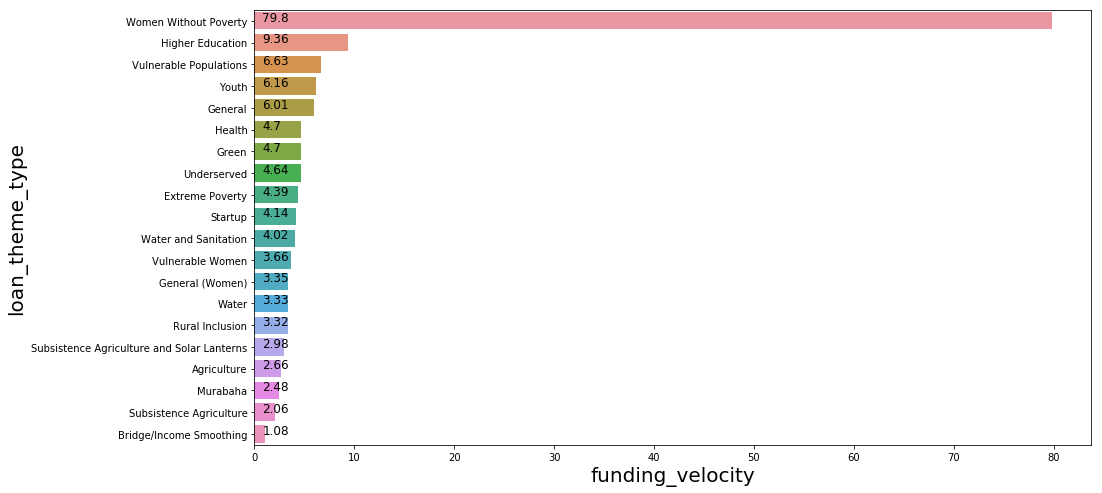

In [212]:
top_themes = data.loan_theme_type.value_counts().head(20).index.values
loans = data.loc[data['loan_theme_type'].isin(top_themes)]

plot_categorical('loan_theme_type', dataset=loans)

Despite the overwhelming `general` category, this feature is very interesting. We should look at it closer to see if we extract something from it in the feature transformation process.

## Country

In [213]:
print(len(data['country'].unique()))
data['country'].value_counts()

75


Philippines                         149517
Kenya                                63349
Cambodia                             32497
Pakistan                             26487
Uganda                               19101
Tajikistan                           19016
El Salvador                          15752
Peru                                 15295
Colombia                             13541
Ecuador                              10978
Nigeria                               9971
India                                 8794
Nicaragua                             8635
Bolivia                               8319
Paraguay                              8139
Palestine                             7771
Armenia                               7604
Samoa                                 6934
Lebanon                               6852
Guatemala                             5041
Honduras                              5025
Tanzania                              5022
Indonesia                             4899
Sierra Leon

#### Common countries

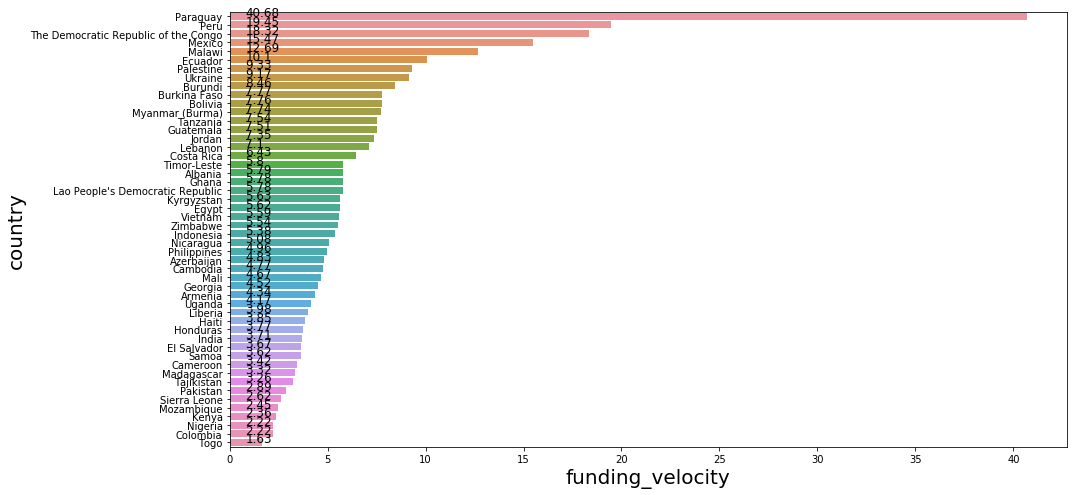

In [214]:
# plot velocity time for most common countries
top_countries = data.country.value_counts().head(50).index.values
countries = data.loc[data['country'].isin(top_countries)]

plt.figure(figsize=(15,8))
plot_categorical('country', countries)

There is significant variation in velocity between countries, so it definitely seems like a useful feature to include.

#### Least common countries

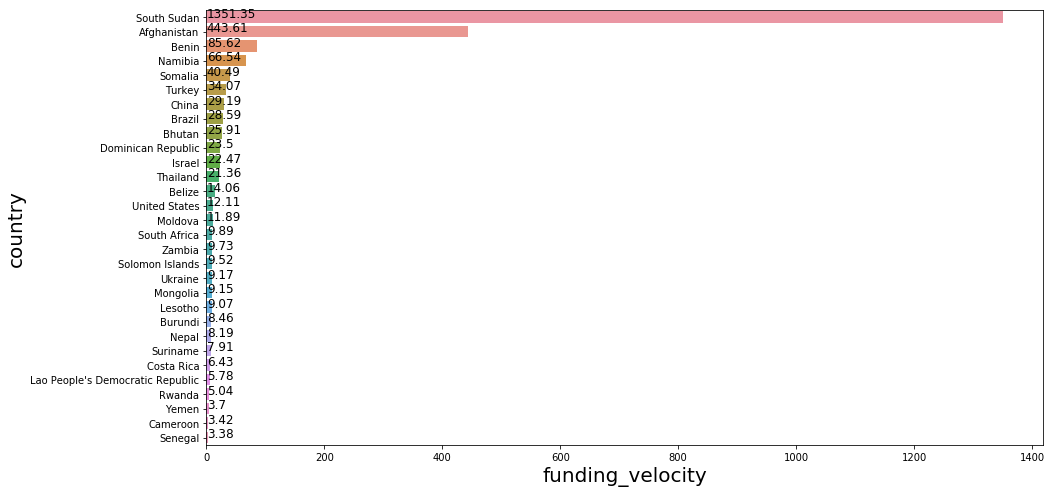

In [215]:
# plot velocity time for least common countries
top_countries = data.country.value_counts().tail(30).index.values
uncommon_countries = data.loc[data['country'].isin(top_countries)]

plt.figure(figsize=(15,8))
plot_categorical('country', uncommon_countries)

Variance not super meaningful with these countries–South Sudan has only one instance.

In [216]:
print(len(data[data['country'] == 'South Sudan']))

1


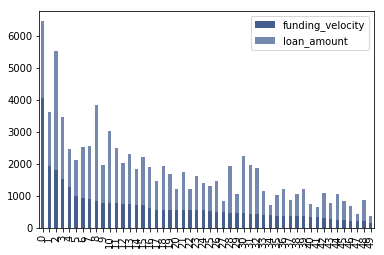

In [219]:
plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='country', 
                     d=countries, 
                     scale_first=True)

Here again, the funding velocity and loan amount are not closely related within each country.

## Loan Terms

### Repayment Interval

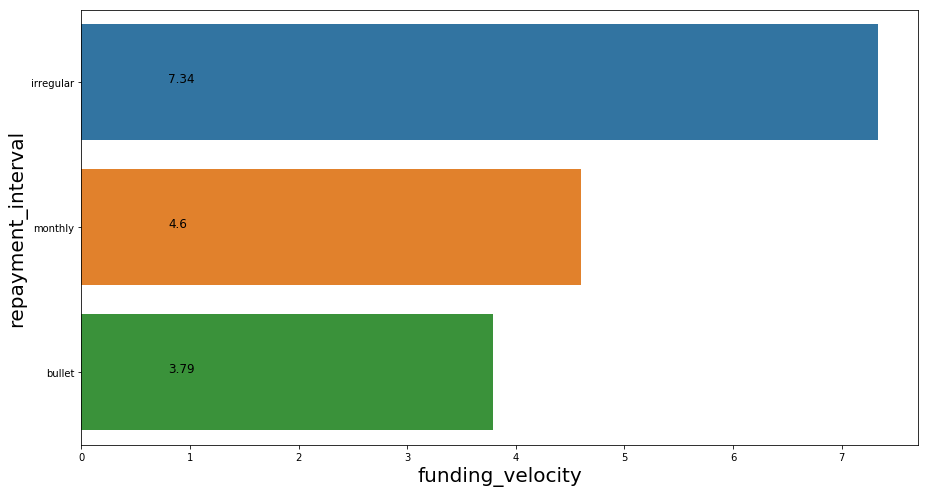

In [220]:
plot_categorical('repayment_interval', countries)

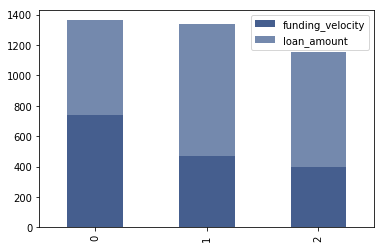

In [221]:
plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='repayment_interval', 
                     d=data, 
                     scale_first=True)

### Term in months

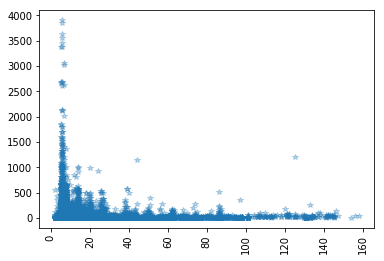

In [222]:
plt.plot(data['term_in_months'], data['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

### Lender Count

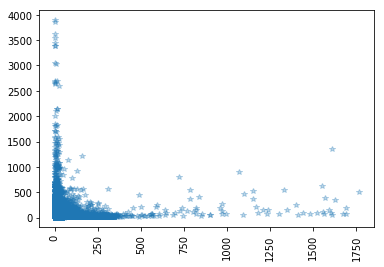

In [223]:
plt.plot(data['lender_count'], data['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

As I would expect, loans with few funders (larger donations) were funded exponentially faster. While this is an important factor, clearly, I wonder about including it in the feature set because we are trying to *predict* funding velocity ahead of time – `lender_count` is not a known factor until after the loan has been funded.

### Field Partner

In [224]:
print(data.field_partner_name.value_counts().head(20))
print("Total Unique Partners: " + str((data.field_partner_name.value_counts()).sum()))

Negros Women for Tomorrow Foundation (NWTF)    103663
CrediCampo                                      15424
Juhudi Kilimo                                   15391
iDE Cambodia                                    14447
BRAC Pakistan                                   13564
SMEP Microfinance Bank                          12987
Paglaum Multi-Purpose Cooperative (PMPC)        12909
Community Economic Ventures, Inc. (CEVI)        12311
HOFOKAM                                         10467
VisionFund Cambodia                             10437
Yehu Microfinance Trust                         10405
Interactuar                                     10331
VisionFund Kenya                                10325
Kashf Foundation                                10203
Babban Gona Farmers Organization                 9845
AsociaciÍ_n Arariwa                              9567
Humo                                             8292
IMON International                               8275
FundaciÍ_n Paraguaya        

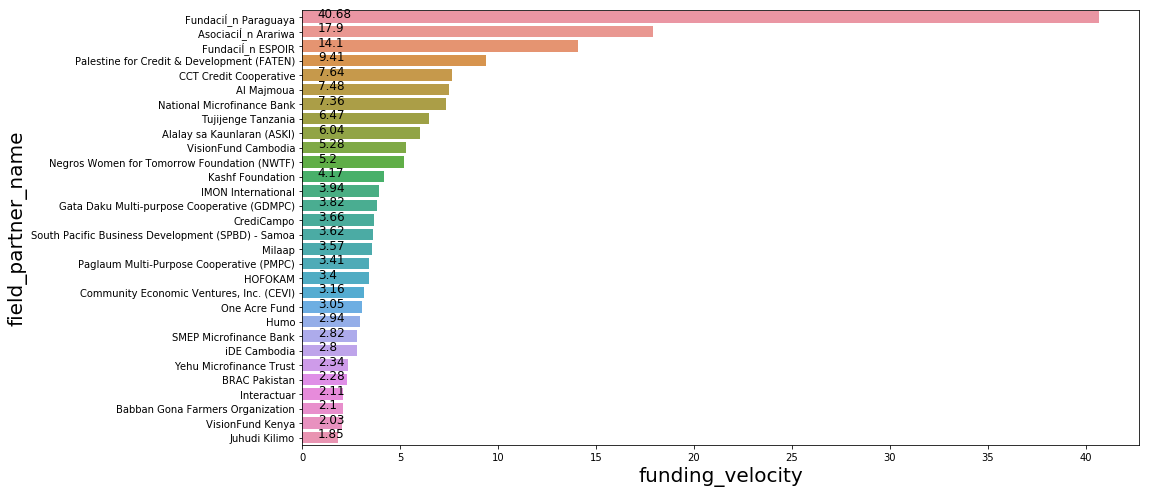

In [225]:
top_partners = data.field_partner_name.value_counts().head(30).index.values
partners = data.loc[data['field_partner_name'].isin(top_partners)]

plt.figure(figsize=(15,8))
plot_categorical('field_partner_name', partners)

I'm noticing that a lot of the field partners have places in the name. Lets see how closely related field partners are to countries.

In [226]:
for partner in top_partners:
    print(partner.upper())
    counts = data[data["field_partner_name"] == partner]['country'].value_counts()
    for i in range(len(counts)):
        print(counts.index[i])
        print(counts[i])
    print()

NEGROS WOMEN FOR TOMORROW FOUNDATION (NWTF)
Philippines
103663

CREDICAMPO
El Salvador
15424

JUHUDI KILIMO
Kenya
15391

IDE CAMBODIA
Cambodia
14447

BRAC PAKISTAN
Pakistan
13564

SMEP MICROFINANCE BANK
Kenya
12987

PAGLAUM MULTI-PURPOSE COOPERATIVE (PMPC)
Philippines
12909

COMMUNITY ECONOMIC VENTURES, INC. (CEVI)
Philippines
12311

HOFOKAM
Uganda
10467

VISIONFUND CAMBODIA
Cambodia
10437

YEHU MICROFINANCE TRUST
Kenya
10405

INTERACTUAR
Colombia
10331

VISIONFUND KENYA
Kenya
10325

KASHF FOUNDATION
Pakistan
10203

BABBAN GONA FARMERS ORGANIZATION
Nigeria
9845

ASOCIACIÍ_N ARARIWA
Peru
9567

HUMO
Tajikistan
8292

IMON INTERNATIONAL
Tajikistan
8275

FUNDACIÍ_N PARAGUAYA
Paraguay
8139

GATA DAKU MULTI-PURPOSE COOPERATIVE (GDMPC)
Philippines
7410

ONE ACRE FUND
Kenya
7187

SOUTH PACIFIC BUSINESS DEVELOPMENT (SPBD) - SAMOA
Samoa
6934

CCT CREDIT COOPERATIVE
Philippines
6917

PALESTINE FOR CREDIT & DEVELOPMENT (FATEN)
Palestine
6687

AL MAJMOUA
Lebanon
5925

FUNDACIÍ_N ESPOIR
Ecuador
5603


It looks like these partners are closely tied to countries. Lets see how closely countries are tied to partners.

In [227]:
top_countries = data.country.value_counts().head(30).index.values

for country in top_countries:
    print(country.upper())
    counts = data[data["country"] == country]['field_partner_name'].value_counts()
    for i in range(len(counts)):
        print(counts.index[i])
        print(counts[i])
    print()

PHILIPPINES
Negros Women for Tomorrow Foundation (NWTF)
103663
Paglaum Multi-Purpose Cooperative (PMPC)
12909
Community Economic Ventures, Inc. (CEVI)
12311
Gata Daku Multi-purpose Cooperative (GDMPC)
7410
CCT Credit Cooperative
6917
Alalay sa Kaunlaran (ASKI)
5509
SEED Center Philippines
620
BagoSphere
177
N/A, direct to Kalsada
1

KENYA
Juhudi Kilimo
15391
SMEP Microfinance Bank
12987
Yehu Microfinance Trust
10405
VisionFund Kenya
10325
One Acre Fund
7187
Hand in Hand Eastern Africa
3248
Kenya ECLOF
2849
Digital Divide Data (DDD)
233
Sanergy
225
Asante Kenya Foundation
152
Junior Achievement Kenya
74
iSmart Kenya
74
Takamoto Biogas
72
Burn Manufacturing
44
Housing Finance Foundation
29
Moringa School
24
Strathmore University
17
PowerGen Renewable Energy
2
Unreasonable Institute
2
N/A, direct to SCODE
1
N/A, direct to Moko Furniture (Watervale Investments)
1
N/A, direct to EcoZoom
1
N/A, direct to Pawame
1
Fledge
1
N/A, direct to Vava Coffee
1
N/A, direct to ICT4D
1
N/A, direct to Eco

It seems like partners are a very local thing, tied closely to countries. Because of this, I doubt that kiva funders would have the background knowledge required to make partners a part of their decision. This could be looked at more,  but I'm going to put it aside for now.

Using countries (which partners are closely correlated with) is likely much more useful for our model.

## Currency

In [228]:
len(data['currency'].unique())

62

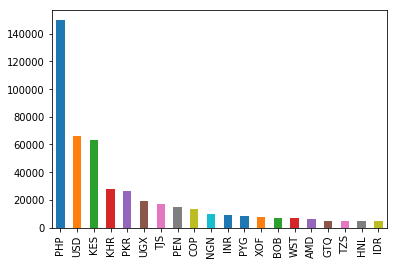

In [229]:
data.currency.value_counts().head(20).plot.bar()

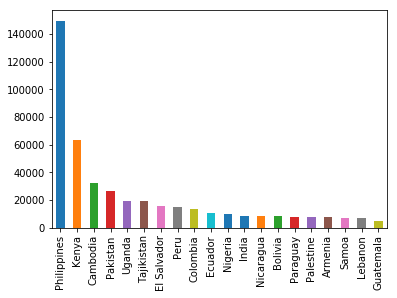

In [230]:
data.country.value_counts().head(20).plot.bar()

Looks like the main difference between country and currency is that USD is an aggregate of many countries.

In [231]:
usd = data[data["currency"] == "USD"]["country"].value_counts()
print("USD:")
print(usd)
print()

print("PHP:")
usd = data[data["currency"] == "PHP"]["country"].value_counts()
print(usd)

USD:
El Salvador                             15752
Ecuador                                 10978
Palestine                                7759
Lebanon                                  5783
Cambodia                                 4827
Nicaragua                                4094
Zimbabwe                                 3533
The Democratic Republic of the Congo     2963
Timor-Leste                              2386
Tajikistan                               1822
Armenia                                  1775
Bolivia                                  1347
Peru                                      742
Georgia                                   714
United States                             484
Mongolia                                  233
Kyrgyzstan                                214
Haiti                                     150
Ghana                                     112
Indonesia                                 103
Thailand                                  101
Honduras                     

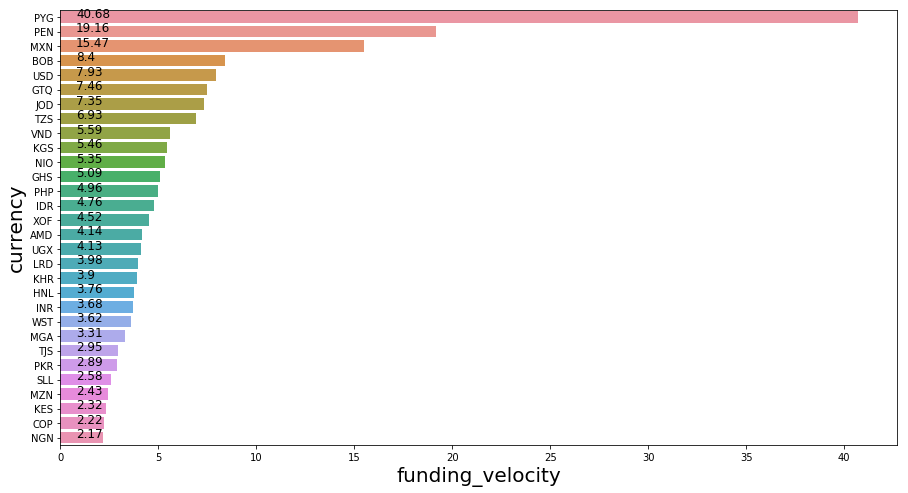

In [232]:
top = data.currency.value_counts().head(30).index.values
c = data.loc[data['currency'].isin(top)]

plot_categorical('currency', c)

Same general trends as the country feature.

## MPI dataset features

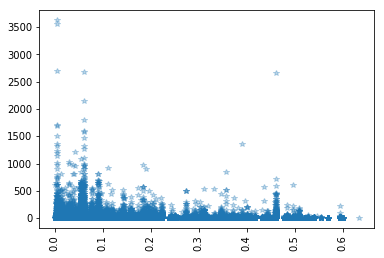

In [233]:
plt.plot(data['mpi_regional'], data['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

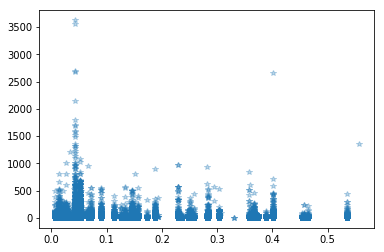

In [236]:
plt.plot(data['mpi_national'], data['funding_velocity'], '*', alpha=0.3)
plt.show()

Interestingly weak relationships here.

# Summary of Exlpored Features

#### Time of the year posted
There appears to be a spike in funding velocity around the holidays every year, and velocity also reaches a low point during the summer months. We will use this feature (`month_posted`) directly as a continuous value.

#### Loan Purpose
We have three main loan purpose related variables:
- `sector`: least granular (15 values), related solely to use
- `activity`:  more granular (160 values), related solely to use
- `loan_theme_type`: more granular (110 values), considers both use and borrower

We should look at these features a little closer in the transformation process, to see how much information we lose in going from `activity` to `sector` before deciding anything futher.

#### Country
Definitely should use, upon some transformation. It probably wouldn't hurt to group together some of the countries with only few instances, if nothing else. We will explore this later, but we definitely want to use it in some way.

#### Repayment Interval
Interestingly, irregular loan terms have the highest velocity. Although it might not seem like the best idea to convert this to a continuous variable, there is a sensible transformation that we will talk about later

#### Term in months
Loans with extremely low terms have a significant bump in velocity. We noticed that “short term loans” is actually a filter on Kiva’s website. Definitely useful.

#### Lender Count - Not useful?
While this shows a similar trend to the previous feature (low lender counts -> high velocity), we're doubtful about wether we should use it in our model because it’s not information that you will have available when predicting a loan’s velocity before it’s funded.

#### Field Partner - Not useful
Highly localized, not useful.


# Data Preparation (for ML)

Now, with a fully populated dataset, we can get into the "normal" ML process, and we'll start this out by taking a look at each feature to see what it is, what data it holds, and if it might be useful as a label or a feature.

- id: This is just a Kiva id that is not really all that useful, so it can probably be removed, since it shouldn't have anything to do with welfare level, just when the loan was created.
    * DROP
- funded_amount: This is definitely not a feature of the data, since what we are trying to do is predict a Percieved Poverty Index which should tell you how quickly a loan will be funded, so we won't know how much of the loan got funded at that period of time, so this can be dropped as well. In any case, this data is partially encoded in the funding velocity, which is effictively the main component of the PPI at this point.
    * DROP
- loan_amount: So this is definitely something that could be helpful in predicting the PPI, since the perception of need could correlate highly with the amount of money the borrower is asking for.
    * FEATURE
- activity: This feature has too many unique values to perform encoding on, and although it might have been interesting to see if we can reduce this feature down, Kiva already did so with `sector`, so this feature can be dropped
    * DROP
- sector: As noted above, this is a less granular version of `activity`, and with only around 16 unique values, it shouldn't be an issue to use a one hot encoding 
    * FEATURE
    * TRANSFORM
- use: We don't want to get into NLP, so we can just drop this
    * DROP
- country_code: Since we plan on using `country` in some way, this can be dropped
    * DROP
- country: **TODO**
    * FEATURE
    * TRANSFORM
- region: This is much too granular to try and find trends within regions, and it's not necessarily useful. People might make certain assumptions about the countries from which loans originate, however people most likely know nothing about the regions, so there probably isn't much correlation in this feature that there isn't already in the country feature.
    * DROP
- currency: This is an interesting one, however we don't think it really matters much to people loaning money, since we believe Kiva takes it upon themselves to handle different currencies. It also correlates highly with `country`, which we are already using as a feature, so this can be dropped.
    * DROP
- posted_time: This feature can not be used by a model due to the fact that it is a DateTime object, and since we've already extracted a useful feature from this information.
    * DROP
- disbursed_time: This is an interesting feature in that some of these times came before the `posted_time`, and others it was after the `funded_time`, which indicates that some third party gave the loan, and is using kiva to ensure that the third party stays funded. Because of this, it is hard to extract useful information (since this data may or may not be included in a new loan) and is in a non-numerical format, so it can be dropped
    * DROP
- funded_time: This was vital for extracing feature, but will not be useful in the model itself, since it is a DateTime object, so it can be dropped
    * DROP
- term_in_months: This is how long the borrower has to pay back the loan, which is potentially a large factor in how people choose what loans they lend money to (i.e. a 24 month loan means that the money might not come back very fast, which might indicate that the borrowers need the money more than someone who needs a loan they can pay back in 3 months), so this is definite feature.
    * FEATURE
- lender_count: This is actually more of a label than anything, but predicting the amount of lenders is less important than predicting how quickly a loan will be funded (even though they might be related), so we will drop it.
    * DROP
- repayment_interval: This feature is one of three strings: 'irregular', 'monthly', and 'bullet'. The first here means that the borrower(s) will pay whenever they can. 'monthly' is fairly self-explanatory, and 'bullet' is when the borrower(s) pay back the entire loan at the end of the lending period. Since we can't use this on it's own, we will have to tranform it to some numerical representation. The most obvious to us is to have them labeled numerically in this order; monthly, irregular, bullet. This should follow somewhat with the length of the payment interval. The reason we placed irregular in the middle is that we believe those who don't think they can pay each month with opt for irregular, expecting they might not have the money within a month.
    * FEATURE
    * TRANSFORM
- loan_theme_id: This is some long string of characters that is of no use to a model, so it can be dropped
    * DROP
- loan_theme_type: **TODO**
    * FEATURE
    * TRANSFORM
- partner_id: This is just a feature used for earlier merges, so this can be dropped, since it doesn't have much to do with the PPI
    * DROP
- field_partner_name: There are way too many different values for this feature, which means it would be impossible to encode it numerically without taking up a ton of space, so we will just drop it.
    * DROP
- sector_ltbr: Some of this data might be useful, but we are already encoding sector, so we can just drop this feature
    * DROP
- forkiva: Although this is an interesting feature, people most likely don't know whether or not a particular loan is or is not 'forkiva', so it won't be very useful in predicting the PPI
    * DROP
- iso: This completely correlated with country, so there isn't much of a reason to keep it, especially if we keep the data for country.
    * DROP
- number: This is the number of loans coming from a perticular field partner for a particular loan theme, which isn't availible to someone trying to lend money on Kiva
    * DROP
- amount: This is similar to the above feature, but denotes the total amount of money funded by a particular field partner in a particular region for a perticular loan theme, which is data most people lending money do not have, so this can be droppped
    * DROP
- locationname: This is just the `mpi_region` and `country` combined into one string, so it isn't all that useful.
    * DROP
- names: This has way to much information in it to be useful in a model, so it can be dropped
    * DROP
- lat, lon: These can be dropped, since we don't want to use numerical location features.
    * DROP
- mpi_region: This is similar to `region`, but significantly less granular, with just over 6% of the values. This might be useable, but it might be difficult to enumerate the data. It also goes to say that these particular regions are somewhat arbitrary, and it might not be completely obvious to a lender.
    * DROP
- rural_pct: Although a lender might not know this exact value, it is likely they at least have some idea regarding how urban a certain country/region is, so this could be an important factor in determining the PPI of a particular loan. In any case, the model will be able to determine whether or not this information is important, so it can be a feature.
    * FEATURE
- world_region: With only 6 different values, this would not be hard to encode, and gives the least granular indication for the location of a loan, which is what a lender is most likely to know.
    * FEATURE
    * TRANSFORM
- mpi_national, mpi_regional, headcount_ratio_regional, intensity_of_deprivation_regional, mpi_urban, headcount_ratio_urban, intensity_of_deprivation_urban, mpi_rural, headcount_ratio_rural, intensity_of_deprivation_rural: These features are all fairly granular data that could be vital to predicting PPI, so these are all features.
    * FEATURE
- mpi_region_lat, mpi_region_lon: These are numarical location features, which we don't want to use, so they can be dropped
    * DROP
- tag_\*: All of the tag_ features are going to play heavily in how Kiva displays a certain loan, so they could all be very important in predicting PPI
    * FEATURE
- num_tags: Although in theoty this data is encapsulated in the tag_ features, it can't hurt to aggregate the data so that the model doesn't have to figure it out on its own
    * FEATURE
- num_borrowers, num_male_borrowers, ratio_male, num_female_borrowers, ratio_female: These might play an interesting role in computing the PPI, and we extracted them all, so it would be a waste to throw them out.
    * FEATURE
- time_till_funded: This was just an intermediary feature for computing `hours_till_funded`, and since it is a TimeDelta, it can be dropped.
    * DROP
- hours_till_funded: This is without a doubt some sort of label, since this is only information that can be extracted after the loan has gotten funding, but predicting this might be an issue. This and `funded_amount` were used to compute `funding_velocity`, so in theory all of the information in the feature is encoded within funding velocity, so it can safely be dropped
    * DROP
- expected_funding_velocity: This is computed from a linear regression, and we don't want the model we use to predict PPI to just fit the simple linear model.
    * DROP
- expected_hours_till_funded: This feature is just a transformation of `expected_funding_velocity`, so it has the same issues with that feaure
    * DROP
- percent_funded, fully_funded: These two are definitely labels, and they are very similar to one another. Because of this, it seems rather pointless to have them both as labels, since it would just mean more computation. Although `percent_funded` could be useful, it it far too likely for the model to never give a full 100% to predictions, which is inaccurate, since most loans will get funded. Because of this, we believ it should be dropped, and just use `fully_funded`. It will have to be transformed however so that false has a value of -1, and true a value of 1, so that it will be an easy tranformation after prediction to just say anything > 0 is true, and anything < 0 is false.
    * DROP `precent_funded`
    * LABEL `fully_funded`
        - TRANSFORM
- funding_velocity: This is the main label of this entire dataset, and is effectively what the PPI is, so there is no doubt that this will be kept as a label
    * LABEL

The first thing we'll do is write this dataset to disk, reset the kernel, and re-read the file back in, so that we have a nice clean version of the dataset right off the bat, rather than having to re-run the kernel every time if we mess something up.

In [501]:
final_data.to_csv('final_data.csv')
%reset -f

# Imports

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [340]:
final_data = pd.read_csv('final_data.csv')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533461 entries, 0 to 533460
Data columns (total 94 columns):
Unnamed: 0                           533461 non-null int64
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null object
disbursed_time                       533461 non-null object
funded_time                          499549 non-null object
term_in_months                       533461 non-n

In [176]:
drop_labels = \
'''
id
funded_amount
activity
use
country_code
region
currency
posted_time
disbursed_time
funded_time
lender_count
loan_theme_id
partner_id
field_partner_name
sector_ltbr
forkiva
iso
number
amount
locationname
names
lat
lon
mpi_region
mpi_region_lat
mpi_region_lon
time_till_funded
hours_till_funded
expected_funding_velocity
expected_hours_till_funded
percent_funded
'''.split('\n')[1:-1]

final_data.drop(drop_labels, axis=1, inplace=True)
final_data.info()

ValueError: labels ['id' 'funded_amount' 'activity' 'region' 'currency' 'posted_time'
 'disbursed_time' 'funded_time' 'lender_count' 'loan_theme_id'
 'partner_id' 'field_partner_name' 'sector_ltbr' 'forkiva' 'iso' 'number'
 'amount' 'locationname' 'names' 'lat' 'lon' 'mpi_region' 'mpi_region_lat'
 'mpi_region_lon' 'time_till_funded' 'hours_till_funded'
 'expected_funding_velocity' 'expected_hours_till_funded' 'percent_funded'] not contained in axis